In [31]:
# Setup and imports
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
import numpy as np
import yaml
from scipy import stats
import matplotlib.pyplot as plt

sys.path.insert(1, '/home/jw3514/Work/UNIMED/src')
from CellType_PSY import *
from UNIMED import *

# Load gene information
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol = LoadGeneINFO()

# Set working directory
os.chdir("/home/jw3514/Work/UNIMED/notebooks/")

# Load configuration
with open("../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Function definitions for reusable analysis

def load_bias_matrix_and_psd(config):
    """Load bias matrix and calculate PSD scores"""
    bias_path = config["bias_matrices"]["MouseSTR"]
    bias_mat = pd.read_csv(bias_path, index_col=0)
    
    # Jon's PSD gene list
    jon_psd_list = "88 102 107 114 118 119 120 150 375 476 491 538 575 577 613 659 664 747 775 815 832 1000 1020 1128 1136 1499 1500 1501 1612 1627 1630 1739 1740 1741 1742 1785 1821 1838 1855 1948 1949 2039 2043 2059 2066 2171 2185 2332 2534 2596 2785 2852 2890 2891 2892 2893 2894 2895 2897 2898 2899 2900 2901 2902 2903 2904 2905 2906 2911 2913 2915 3184 3188 3337 3631 3646 3708 3756 3836 4038 4131 4218 4355 4744 4804 4842 4897 4905 4915 4985 5028 5062 5063 5064 5071 5093 5094 5142 5170 5582 5590 5621 5662 5728 5800 5802 6009 6128 6129 6132 6136 6156 6169 6175 6188 6207 6208 6222 6223 6230 6232 6252 6334 6457 6536 6543 6546 6547 6695 6711 6790 6792 6801 6853 6854 7074 7248 7249 7428 7732 7779 8087 8224 8440 8502 8516 8661 8777 8787 8825 8831 8851 8898 8927 8997 9026 9045 9101 9148 9162 9194 9201 9228 9229 9231 9419 9454 9455 9456 9463 9478 9495 9513 9743 9746 9762 9829 9863 9867 9890 9912 9921 9922 10006 10142 10243 10280 10313 10368 10369 10458 10486 10505 10509 10611 10636 11122 11178 11331 11346 22829 22849 22865 22866 22871 22883 22941 22986 22997 23043 23208 23229 23237 23362 23380 23413 23426 23513 23542 23623 23705 23767 25945 25978 26012 26037 26045 26052 27020 27091 27092 27185 27445 28964 28988 29102 29904 50488 50944 51104 51201 51225 54477 54487 54583 54910 55327 55450 55607 55737 56899 56924 57120 57142 57479 57502 57537 57554 57622 57679 57689 58489 58512 59283 59284 64084 64101 64130 64506 66000 78999 79414 79870 79953 80315 80725 80758 80852 80863 81831 81832 81926 84062 84435 84687 85358 85461 94030 112476 114798 116443 116444 145581 145773 146395 152404 158866 160622 200933 201191 254263 339451 347731 373509 388135 388336 392862 400745 401190 440073 440829 642938 729956 729993 100131897"
    jon_psd_list = [int(x) for x in jon_psd_list.split(" ")]
    jon_psd_gw = dict(zip(jon_psd_list, np.ones(len(jon_psd_list))))
    mouse_str_psd = MouseSTR_AvgZ_Weighted(bias_mat, jon_psd_gw)
    
    return bias_mat, mouse_str_psd

def load_pc_scores(pc_scores_path):
    """Load and sort PC scores"""
    pc_scores_df = pd.read_csv(pc_scores_path, index_col=0)
    return pc_scores_df.sort_values(by="PC1", ascending=False)

def load_connectivity_data(score_mat_dir):
    """Load connectivity matrices"""
    ipsi_info_mat = pd.read_csv(score_mat_dir + "InfoMat.Ipsi.csv", index_col=0)
    weight_mat = pd.read_csv(score_mat_dir + "WeightMat.Ipsi.csv", index_col=0)
    ipsi_info_mat_short = pd.read_csv(score_mat_dir + "InfoMat.Ipsi.Short.3900.csv", index_col=0)
    ipsi_info_mat_long = pd.read_csv(score_mat_dir + "InfoMat.Ipsi.Long.3900.csv", index_col=0)
    
    return ipsi_info_mat, weight_mat, ipsi_info_mat_short, ipsi_info_mat_long

In [33]:
def calculate_connection_statistics(weight_mat):
    """Calculate connection statistics for each structure"""
    conn_stats = {}
    
    for structure in weight_mat.index:
        # Get outgoing weights for this structure (row - as source)
        outgoing_weights = weight_mat.loc[structure]
        
        # Get incoming weights for this structure (column - as target)
        incoming_weights = weight_mat[structure]
        
        # Outgoing connections statistics
        num_outgoing_connections = (outgoing_weights != 0).sum()
        total_outgoing_weights = outgoing_weights.sum()
        
        # Incoming connections statistics
        num_incoming_connections = (incoming_weights != 0).sum()
        total_incoming_weights = incoming_weights.sum()
        
        conn_stats[structure] = {
            'num_outgoing_connections': num_outgoing_connections,
            'total_outgoing_weights': total_outgoing_weights,
            'num_incoming_connections': num_incoming_connections,
            'total_incoming_weights': total_incoming_weights
        }
    
    # Convert to DataFrame for easier analysis
    conn_stats_df = pd.DataFrame.from_dict(conn_stats, orient='index')
    conn_stats_df["num_connections"] = conn_stats_df["num_outgoing_connections"] + conn_stats_df["num_incoming_connections"]
    conn_stats_df["total_weights"] = conn_stats_df["total_outgoing_weights"] + conn_stats_df["total_incoming_weights"]
    
    return conn_stats_df

def merge_data_for_analysis(conn_stats_df, pc_scores_df, psd_scores):
    """Merge all datasets for analysis"""
    merged_df = conn_stats_df.join(pc_scores_df, how='inner')
    merged_df = merged_df.join(psd_scores, how='inner')
    merged_df = merged_df.rename(columns={'EFFECT': 'PSD'})
    
    # Calculate total connections and weights
    merged_df['total_connections'] = merged_df['num_incoming_connections'] + merged_df['num_outgoing_connections']
    merged_df['total_all_weights'] = merged_df['total_incoming_weights'] + merged_df['total_outgoing_weights']
    
    return merged_df

In [34]:
def calculate_pc_connectivity_correlations(merged_df, pc_columns=None):
    """Calculate correlations between PC scores and connectivity measures"""
    if pc_columns is None:
        pc_columns = [col for col in merged_df.columns if col.startswith('PC')]
    
    correlation_results = {}
    
    print("Correlations between connection statistics and PC scores:")
    print("-" * 60)
    
    for pc in pc_columns:
        # Correlation with number of outgoing connections
        corr_num_out, p_num_out = stats.spearmanr(merged_df['num_outgoing_connections'], merged_df[pc])
        
        # Correlation with total outgoing weights
        corr_total_out, p_total_out = stats.spearmanr(merged_df['total_outgoing_weights'], merged_df[pc])
        
        # Correlation with number of incoming connections
        corr_num_in, p_num_in = stats.spearmanr(merged_df['num_incoming_connections'], merged_df[pc])
        
        # Correlation with total incoming weights
        corr_total_in, p_total_in = stats.spearmanr(merged_df['total_incoming_weights'], merged_df[pc])
        
        # Total connections and weights
        corr_total_num, p_total_num = stats.spearmanr(merged_df[pc], merged_df['total_connections'])
        corr_total_weights, p_total_weights = stats.spearmanr(merged_df[pc], merged_df['total_all_weights'])
        
        correlation_results[pc] = {
            'num_outgoing_corr': corr_num_out,
            'num_outgoing_p': p_num_out,
            'total_outgoing_corr': corr_total_out,
            'total_outgoing_p': p_total_out,
            'num_incoming_corr': corr_num_in,
            'num_incoming_p': p_num_in,
            'total_incoming_corr': corr_total_in,
            'total_incoming_p': p_total_in,
            'total_connections_corr': corr_total_num,
            'total_connections_p': p_total_num,
            'total_all_weights_corr': corr_total_weights,
            'total_all_weights_p': p_total_weights
        }
        
        print(f"{pc}:")
        print(f"  Outgoing connections: r = {corr_num_out:.3f}, p = {p_num_out:.3e}")
        print(f"  Outgoing weights: r = {corr_total_out:.3f}, p = {p_total_out:.3e}")
        print(f"  Incoming connections: r = {corr_num_in:.3f}, p = {p_num_in:.3e}")
        print(f"  Incoming weights: r = {corr_total_in:.3f}, p = {p_total_in:.3e}")
        print(f"  Total connections: r = {corr_total_num:.3f}, p = {p_total_num:.3e}")
        print(f"  Total weights: r = {corr_total_weights:.3f}, p = {p_total_weights:.3e}")
        print()
    
    # Convert correlation results to DataFrame for easier analysis
    corr_df = pd.DataFrame.from_dict(correlation_results, orient='index')
    print("Summary of correlations:")
    print(corr_df)
    
    return correlation_results, corr_df

In [ ]:
def create_pc_connectivity_plots(merged_df, correlation_results, pc_columns=None, n_pcs=9):
    """Create scatter plots for PC scores vs connectivity measures"""
    if pc_columns is None:
        pc_columns = [col for col in merged_df.columns if col.startswith('PC')]
    
    top_pcs = pc_columns[:n_pcs]
    
    # Plot configurations
    plot_configs = [
        {
            'y_col': 'num_outgoing_connections',
            'y_label': 'Number of Outgoing Connections',
            'title_prefix': 'PC Scores vs Outgoing Connection Count',
            'color': 'blue',
            'corr_key': 'num_outgoing'
        },
        {
            'y_col': 'total_outgoing_weights',
            'y_label': 'Total Outgoing Connection Weights',
            'title_prefix': 'PC Scores vs Total Outgoing Connection Weights',
            'color': 'blue',
            'corr_key': 'total_outgoing'
        },
        {
            'y_col': 'num_incoming_connections',
            'y_label': 'Number of Incoming Connections',
            'title_prefix': 'PC Scores vs Incoming Connection Count',
            'color': 'red',
            'corr_key': 'num_incoming'
        },
        {
            'y_col': 'total_incoming_weights',
            'y_label': 'Total Incoming Connection Weights',
            'title_prefix': 'PC Scores vs Total Incoming Connection Weights',
            'color': 'red',
            'corr_key': 'total_incoming'
        },
        {
            'y_col': 'total_connections',
            'y_label': 'Total Connections (In + Out)',
            'title_prefix': 'PC Scores vs Total Connection Count',
            'color': 'purple',
            'corr_key': 'total_connections'
        },
        {
            'y_col': 'total_all_weights',
            'y_label': 'Total Connection Weights (In + Out)',
            'title_prefix': 'PC Scores vs Total Connection Weights',
            'color': 'purple',
            'corr_key': 'total_all_weights'
        }
    ]
    
    for config in plot_configs:
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        #fig.suptitle(config['title_prefix'], fontsize=16)
        
        for i, pc in enumerate(top_pcs):
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            
            # Create scatter plot
            ax.scatter(merged_df[pc], merged_df[config['y_col']], 
                      alpha=0.6, s=30, color=config['color'])
            
            # Add correlation info
            corr_val = correlation_results[pc][f"{config['corr_key']}_corr"]
            p_val = correlation_results[pc][f"{config['corr_key']}_p"]
            
            ax.set_xlabel(f'{pc} Score')
            ax.set_ylabel(config['y_label'])
            ax.set_title(f'{pc}\\nr = {corr_val:.3f}, p = {p_val:.2e}')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def plot_regional_boxplots(pc_scores_df, regions=None):
    """Create boxplots for PC1 scores by brain region"""
    if regions is None:
        # Create region mapping
        reg2str = {}
        str2reg = STR2Region()
        for structure, region in str2reg.items():
            if region not in reg2str:
                reg2str[region] = []
            reg2str[region].append(structure)
        regions = list(set(str2reg.values()))
    
    plot_pc1_boxplot_structure(pc_scores_df, regions, reg2str, "PC1")

In [36]:
# Load and process data
bias_mat, mouse_str_psd = load_bias_matrix_and_psd(config)
pc_scores_df = load_pc_scores("/home/jw3514/Work/UNIMED/results/pfactor/MouseSTR_PC_Scores.csv")

# Load connectivity data
score_mat_dir = "/home/jw3514/Work/ASD_Circuits/dat/allen-mouse-conn/ScoreingMat_jw_v3/"
ipsi_info_mat, weight_mat, ipsi_info_mat_short, ipsi_info_mat_long = load_connectivity_data(score_mat_dir)

print("Data loaded successfully!")
print(f"Bias matrix shape: {bias_mat.shape}")
print(f"PC scores shape: {pc_scores_df.shape}")
print(f"Weight matrix shape: {weight_mat.shape}")
print(f"PSD scores shape: {mouse_str_psd.shape}")

Data loaded successfully!
Bias matrix shape: (17180, 213)
PC scores shape: (213, 11)
Weight matrix shape: (213, 213)
PSD scores shape: (213, 2)


In [37]:
# Calculate connection statistics and merge data
conn_stats_df = calculate_connection_statistics(weight_mat)
merged_df = merge_data_for_analysis(conn_stats_df, pc_scores_df, mouse_str_psd)

print("Data preprocessing completed!")
print(f"Merged dataset shape: {merged_df.shape}")
print("\nFirst few rows of merged data:")
print(merged_df.head())

Data preprocessing completed!
Merged dataset shape: (213, 21)

First few rows of merged data:
                                      num_outgoing_connections  \
Anterior_amygdalar_area                                      7   
Anterior_cingulate_area_dorsal_part                         48   
Anterior_cingulate_area_ventral_part                         7   
Nucleus_accumbens                                           11   
Anterodorsal_nucleus                                         4   

                                      total_outgoing_weights  \
Anterior_amygdalar_area                             3.068025   
Anterior_cingulate_area_dorsal_part                20.113583   
Anterior_cingulate_area_ventral_part                0.596782   
Nucleus_accumbens                                   1.581500   
Anterodorsal_nucleus                               16.565874   

                                      num_incoming_connections  \
Anterior_amygdalar_area                                   

In [38]:
# Perform correlation analysis
pc_columns = [col for col in merged_df.columns if col.startswith('PC')]
correlation_results, corr_df = calculate_pc_connectivity_correlations(merged_df, pc_columns)

Correlations between connection statistics and PC scores:
------------------------------------------------------------
PC1:
  Outgoing connections: r = -0.007, p = 9.224e-01
  Outgoing weights: r = 0.197, p = 3.854e-03
  Incoming connections: r = -0.007, p = 9.211e-01
  Incoming weights: r = 0.216, p = 1.550e-03
  Total connections: r = 0.030, p = 6.619e-01
  Total weights: r = 0.309, p = 4.215e-06

PC2:
  Outgoing connections: r = 0.141, p = 4.040e-02
  Outgoing weights: r = 0.066, p = 3.387e-01
  Incoming connections: r = -0.087, p = 2.081e-01
  Incoming weights: r = -0.046, p = 5.088e-01
  Total connections: r = 0.085, p = 2.185e-01
  Total weights: r = -0.045, p = 5.170e-01

PC3:
  Outgoing connections: r = -0.149, p = 2.976e-02
  Outgoing weights: r = 0.019, p = 7.842e-01
  Incoming connections: r = 0.163, p = 1.695e-02
  Incoming weights: r = -0.301, p = 8.025e-06
  Total connections: r = -0.080, p = 2.445e-01
  Total weights: r = -0.111, p = 1.059e-01

PC4:
  Outgoing connection

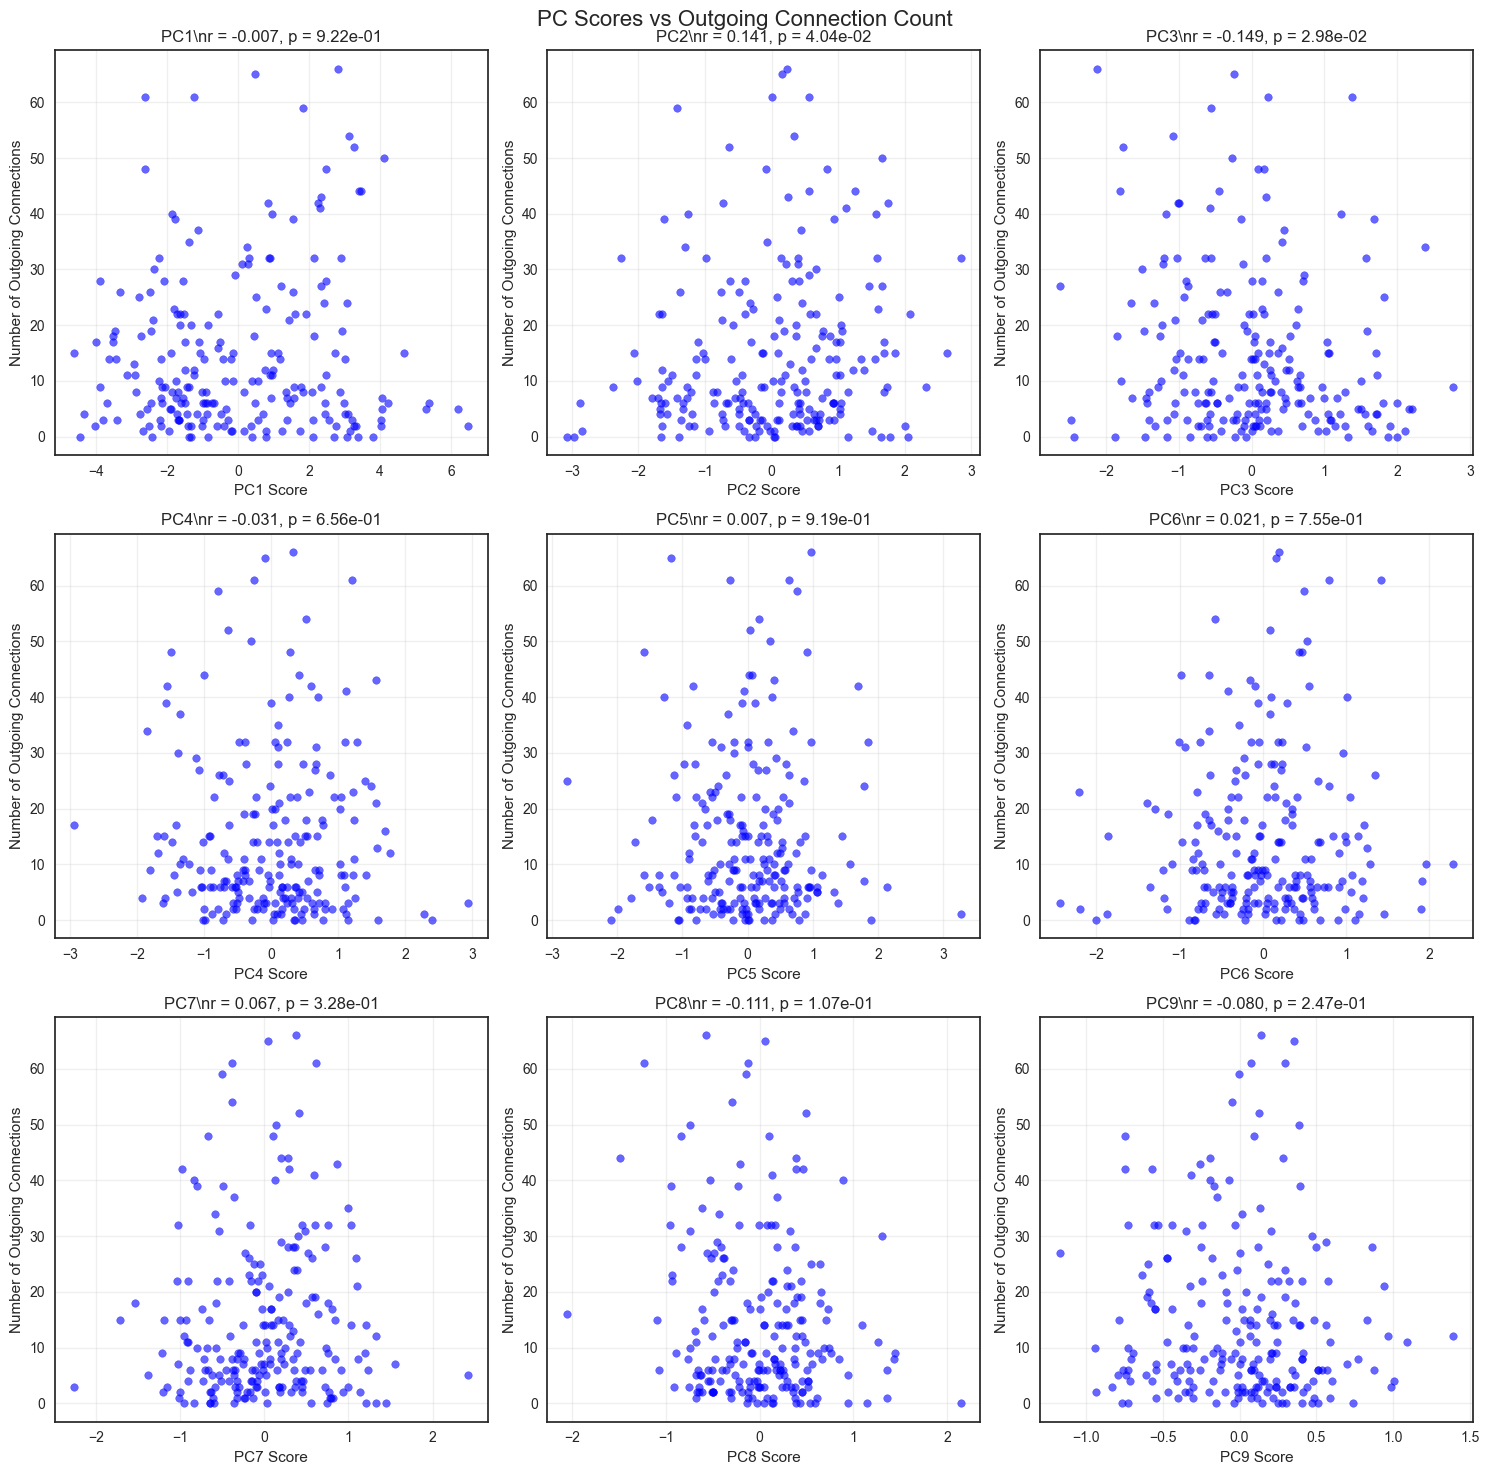

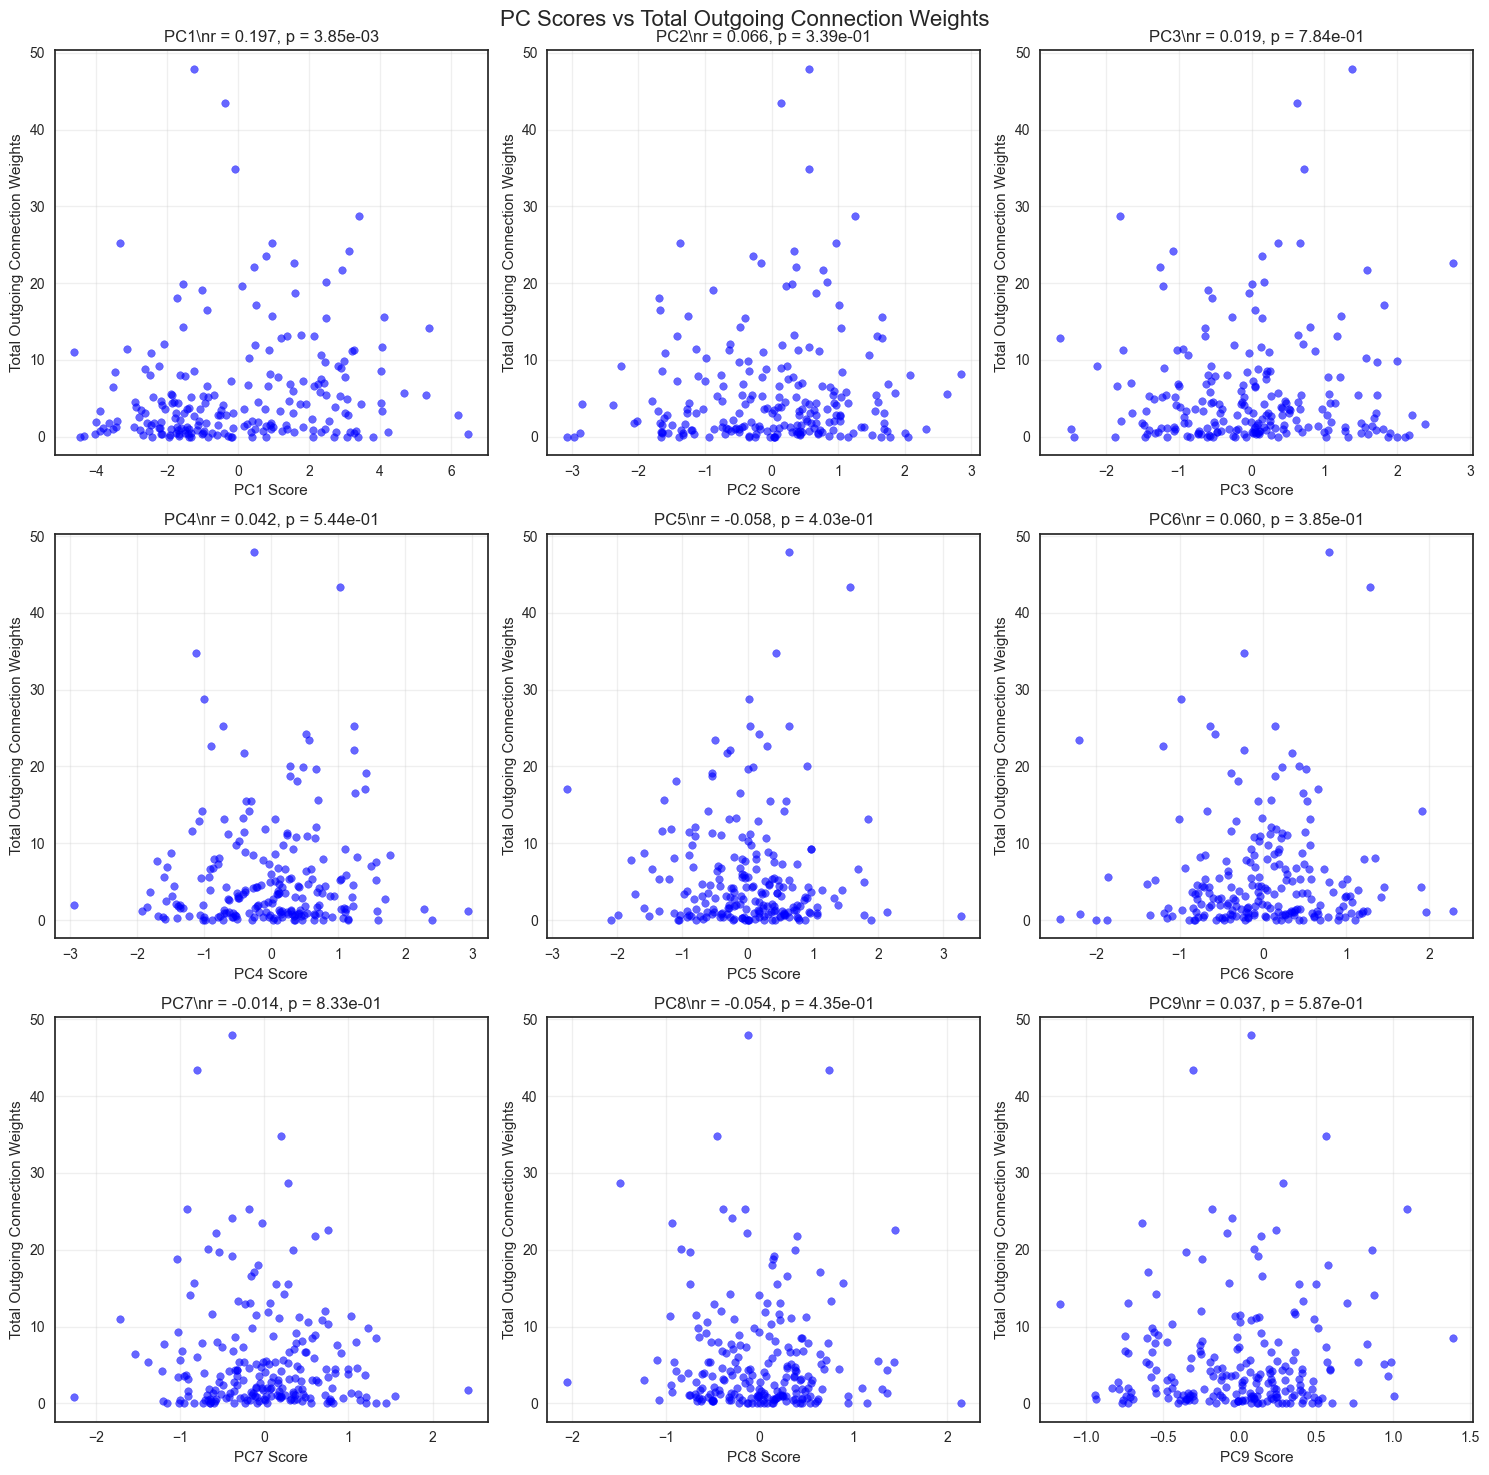

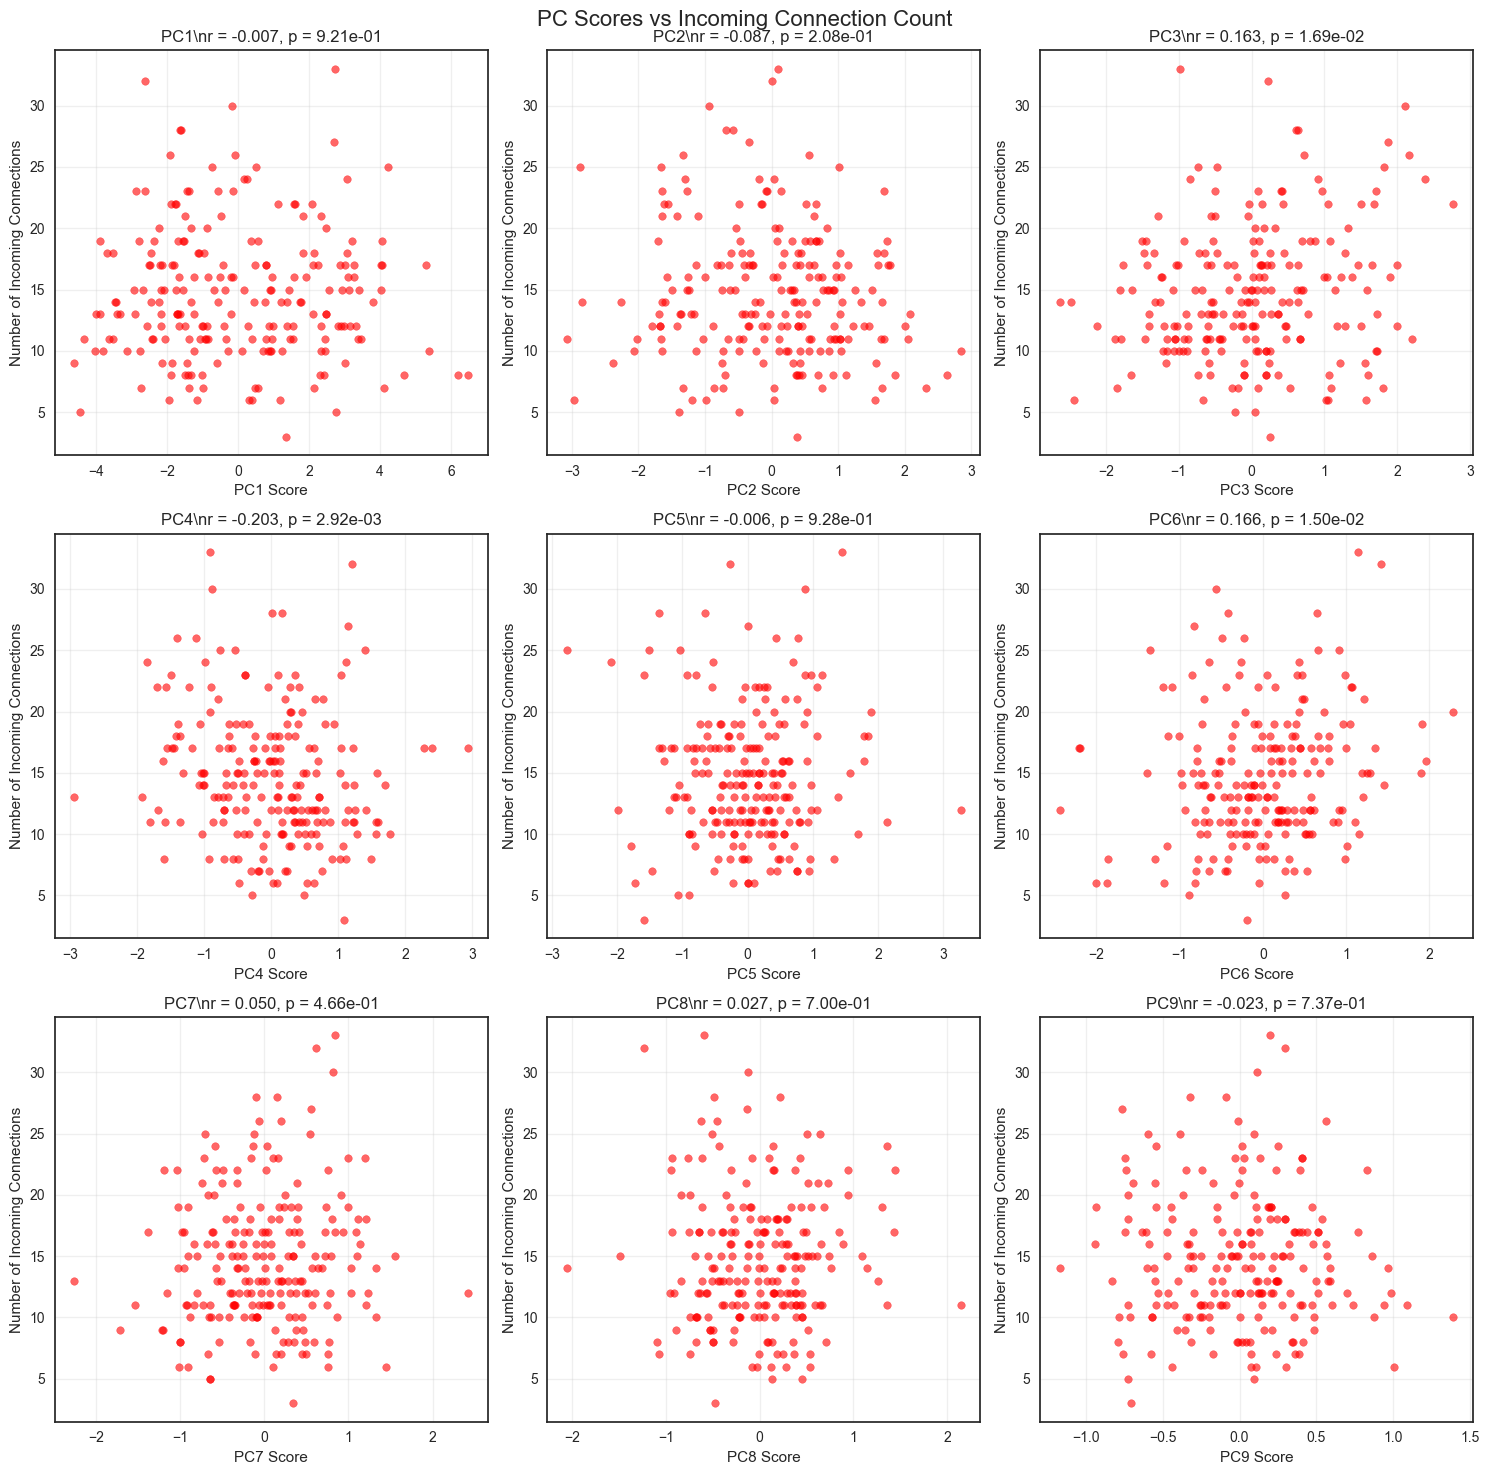

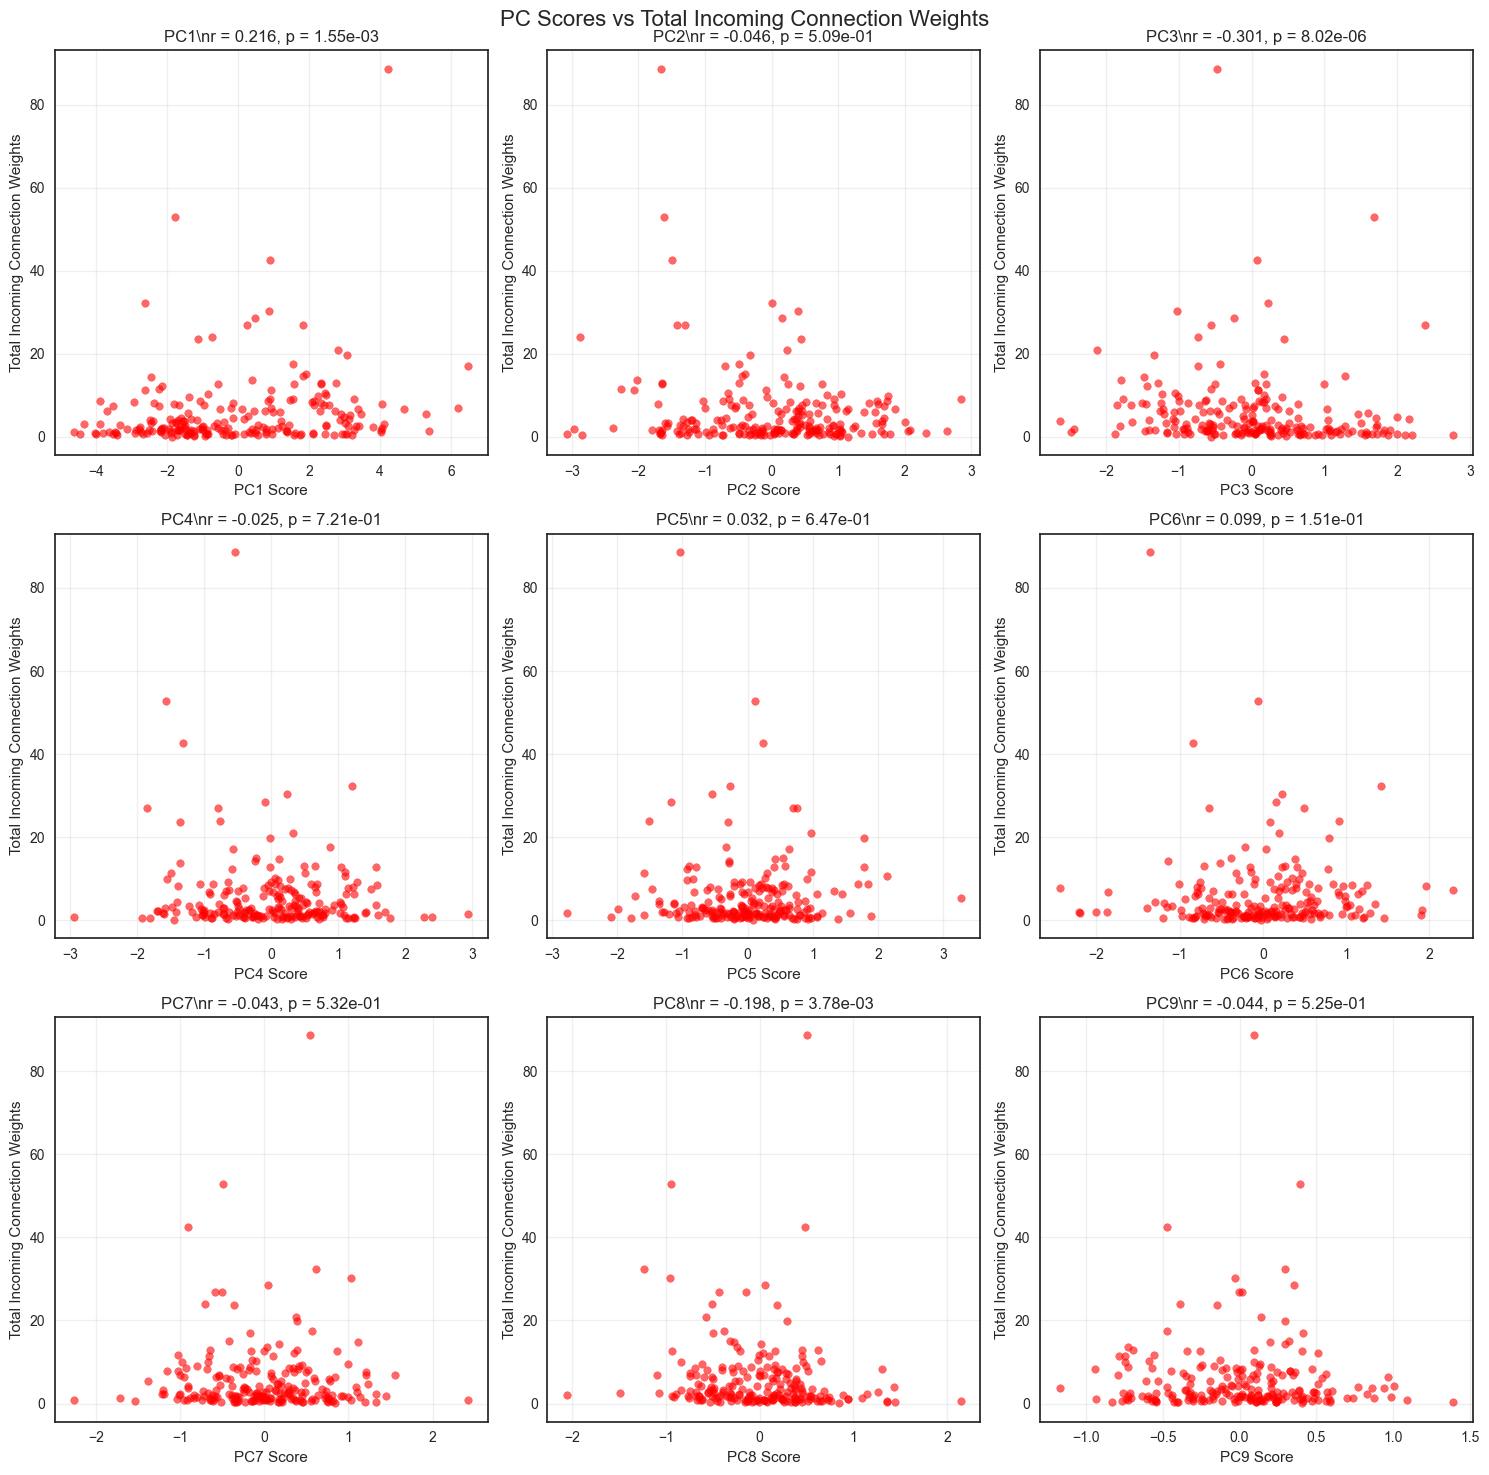

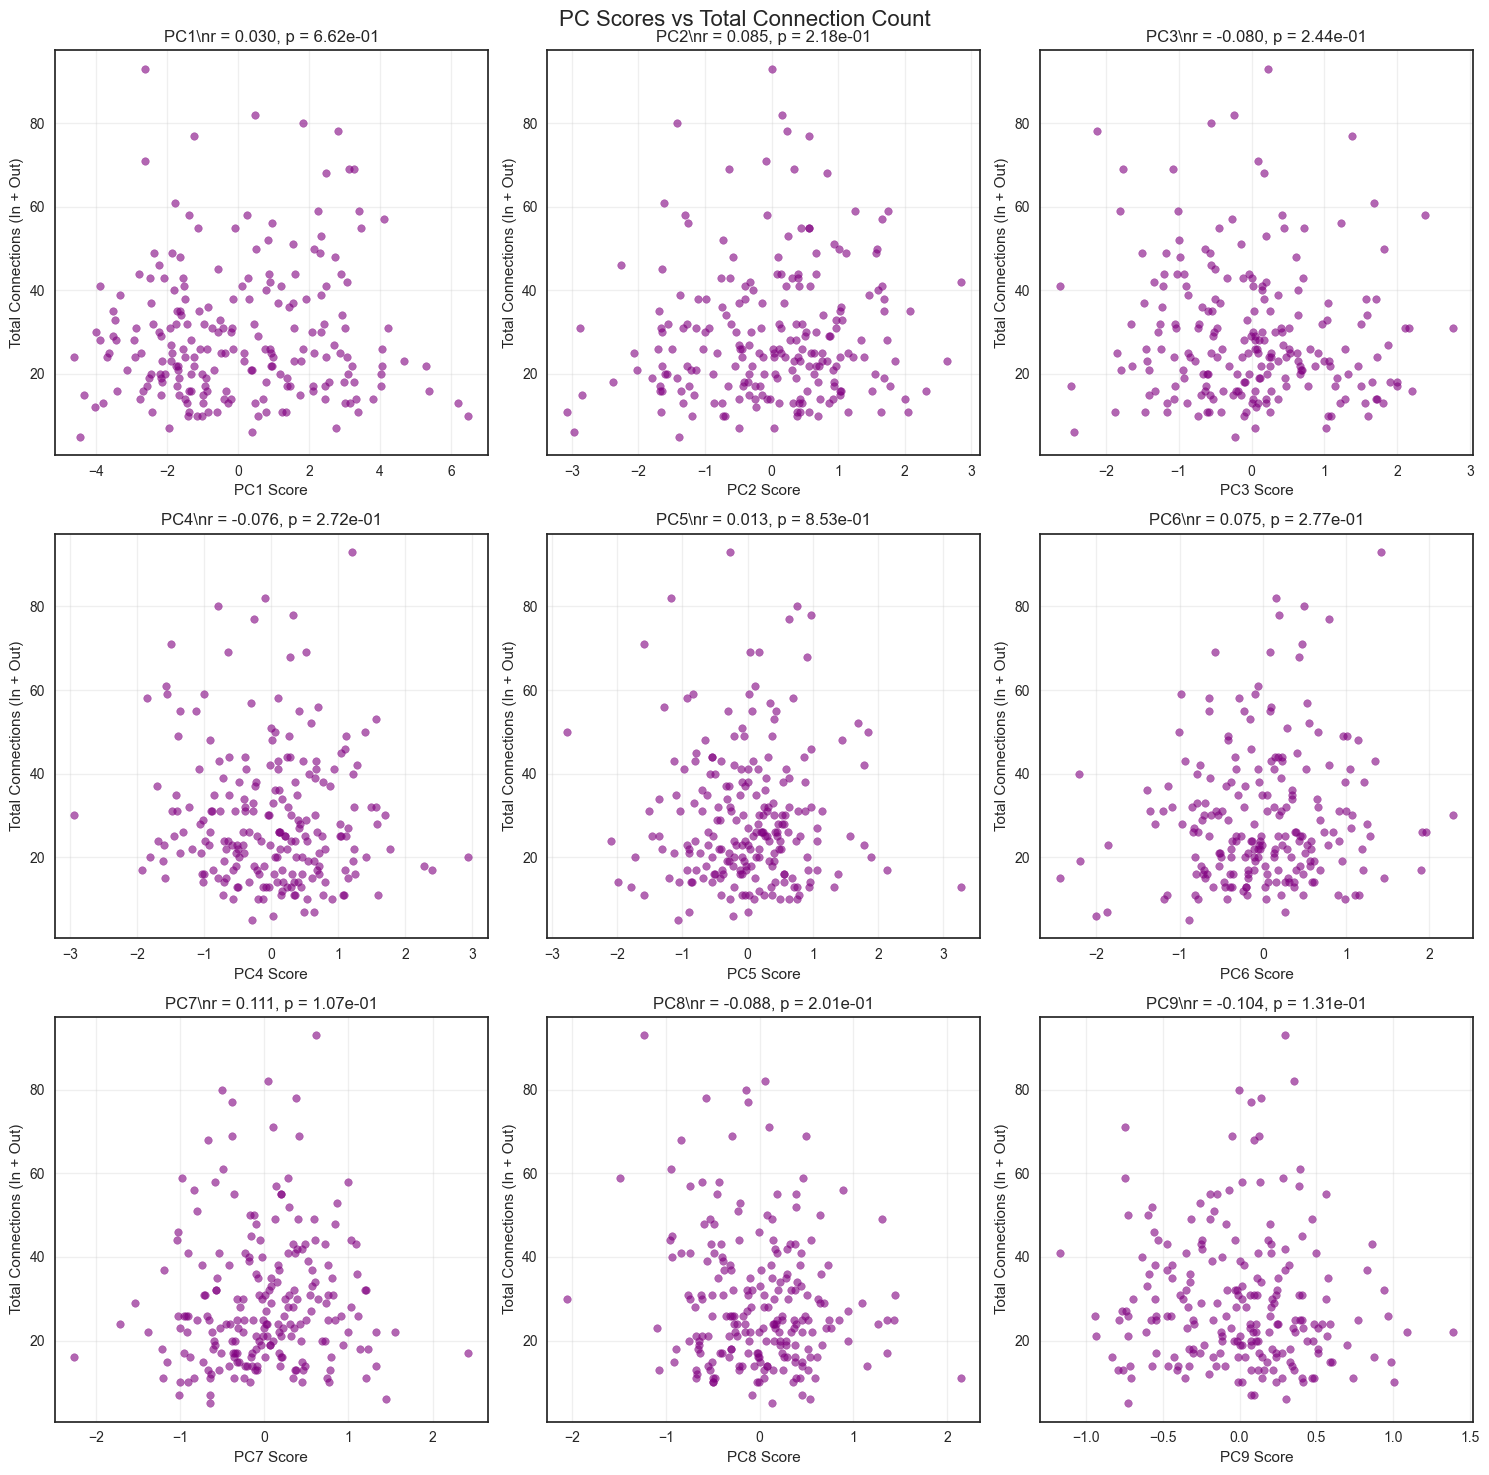

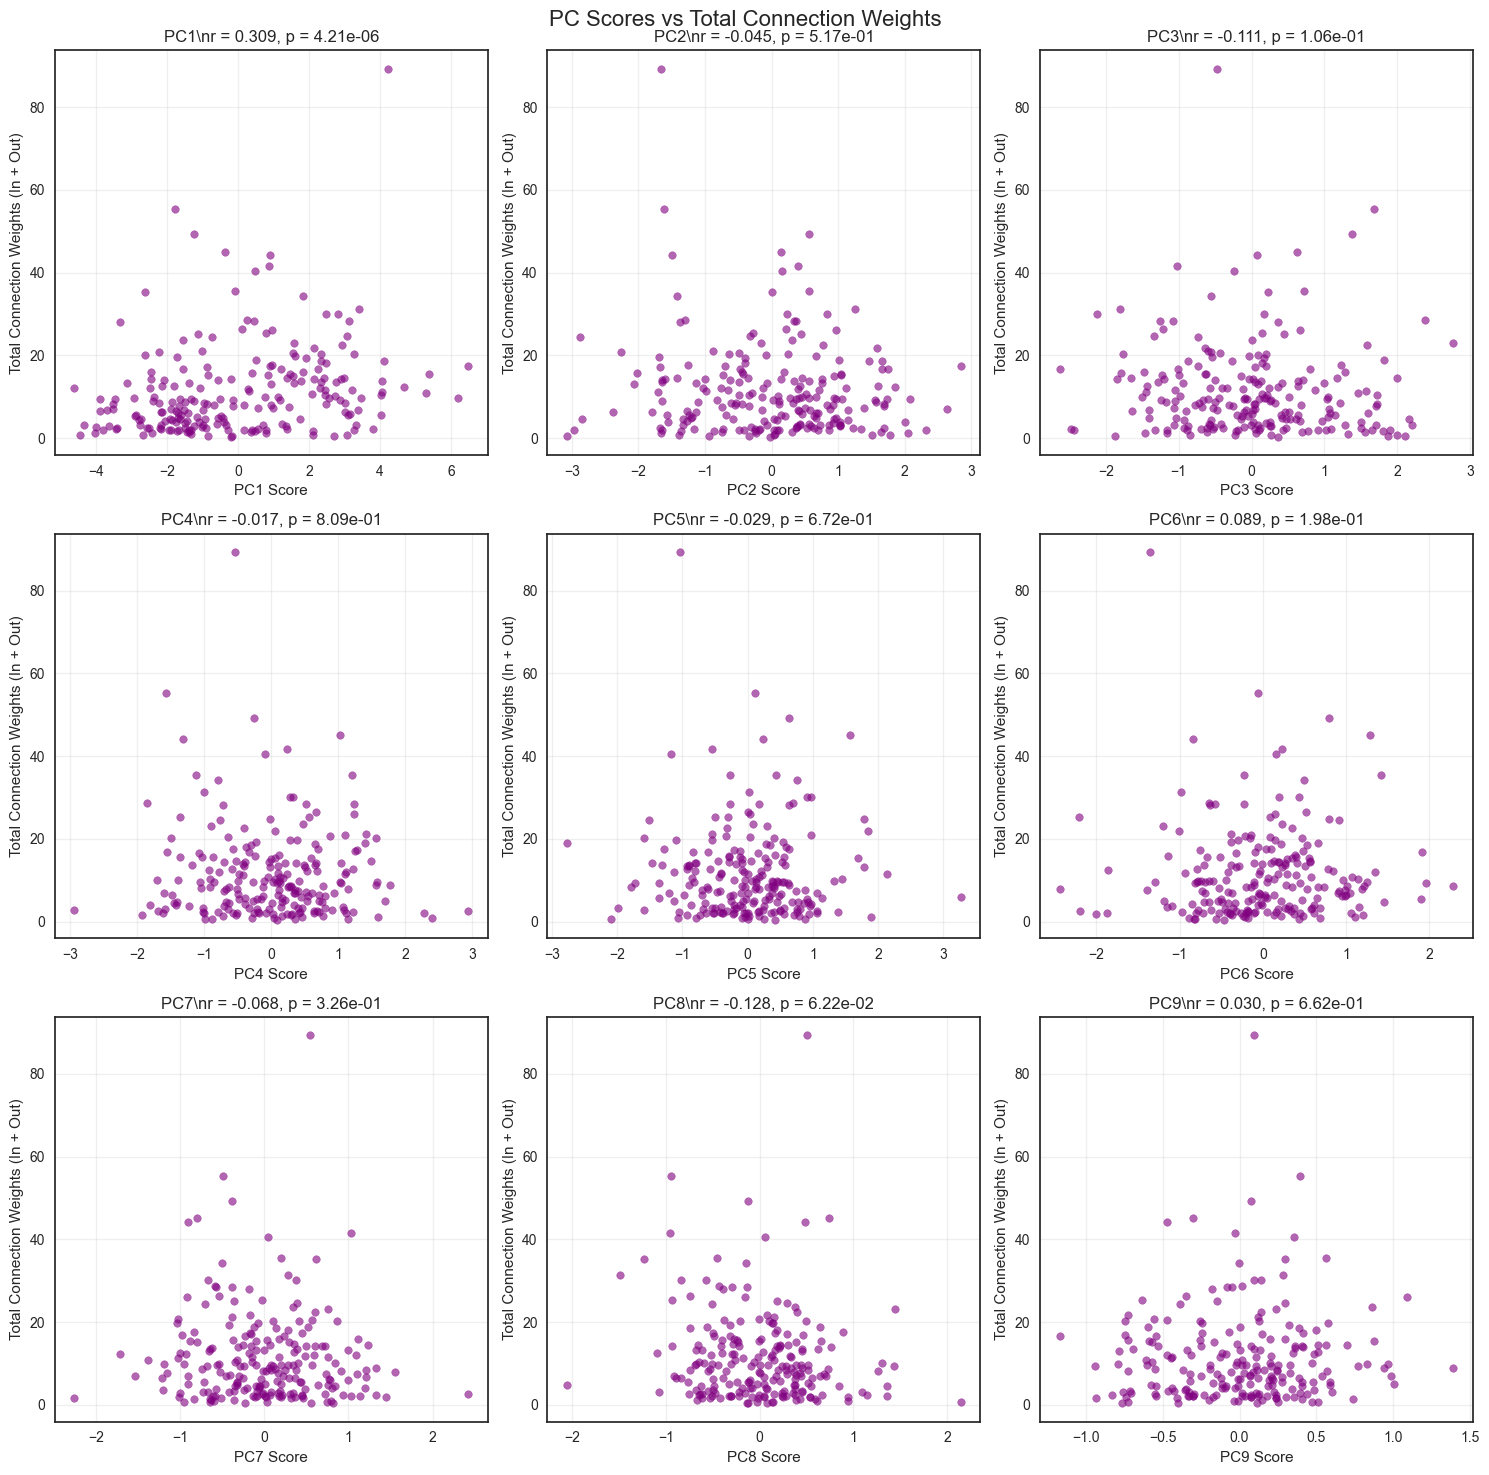

In [39]:
# Generate scatter plots for PC vs connectivity relationships
create_pc_connectivity_plots(merged_df, correlation_results, pc_columns, n_pcs=9)

Pons
Cerebellum
Striatum
Thalamus
Medulla
Midbrain
Cortical_subplate
Olfactory_areas
Pallidum
Hypothalamus
Amygdala
Isocortex
Hippocampus


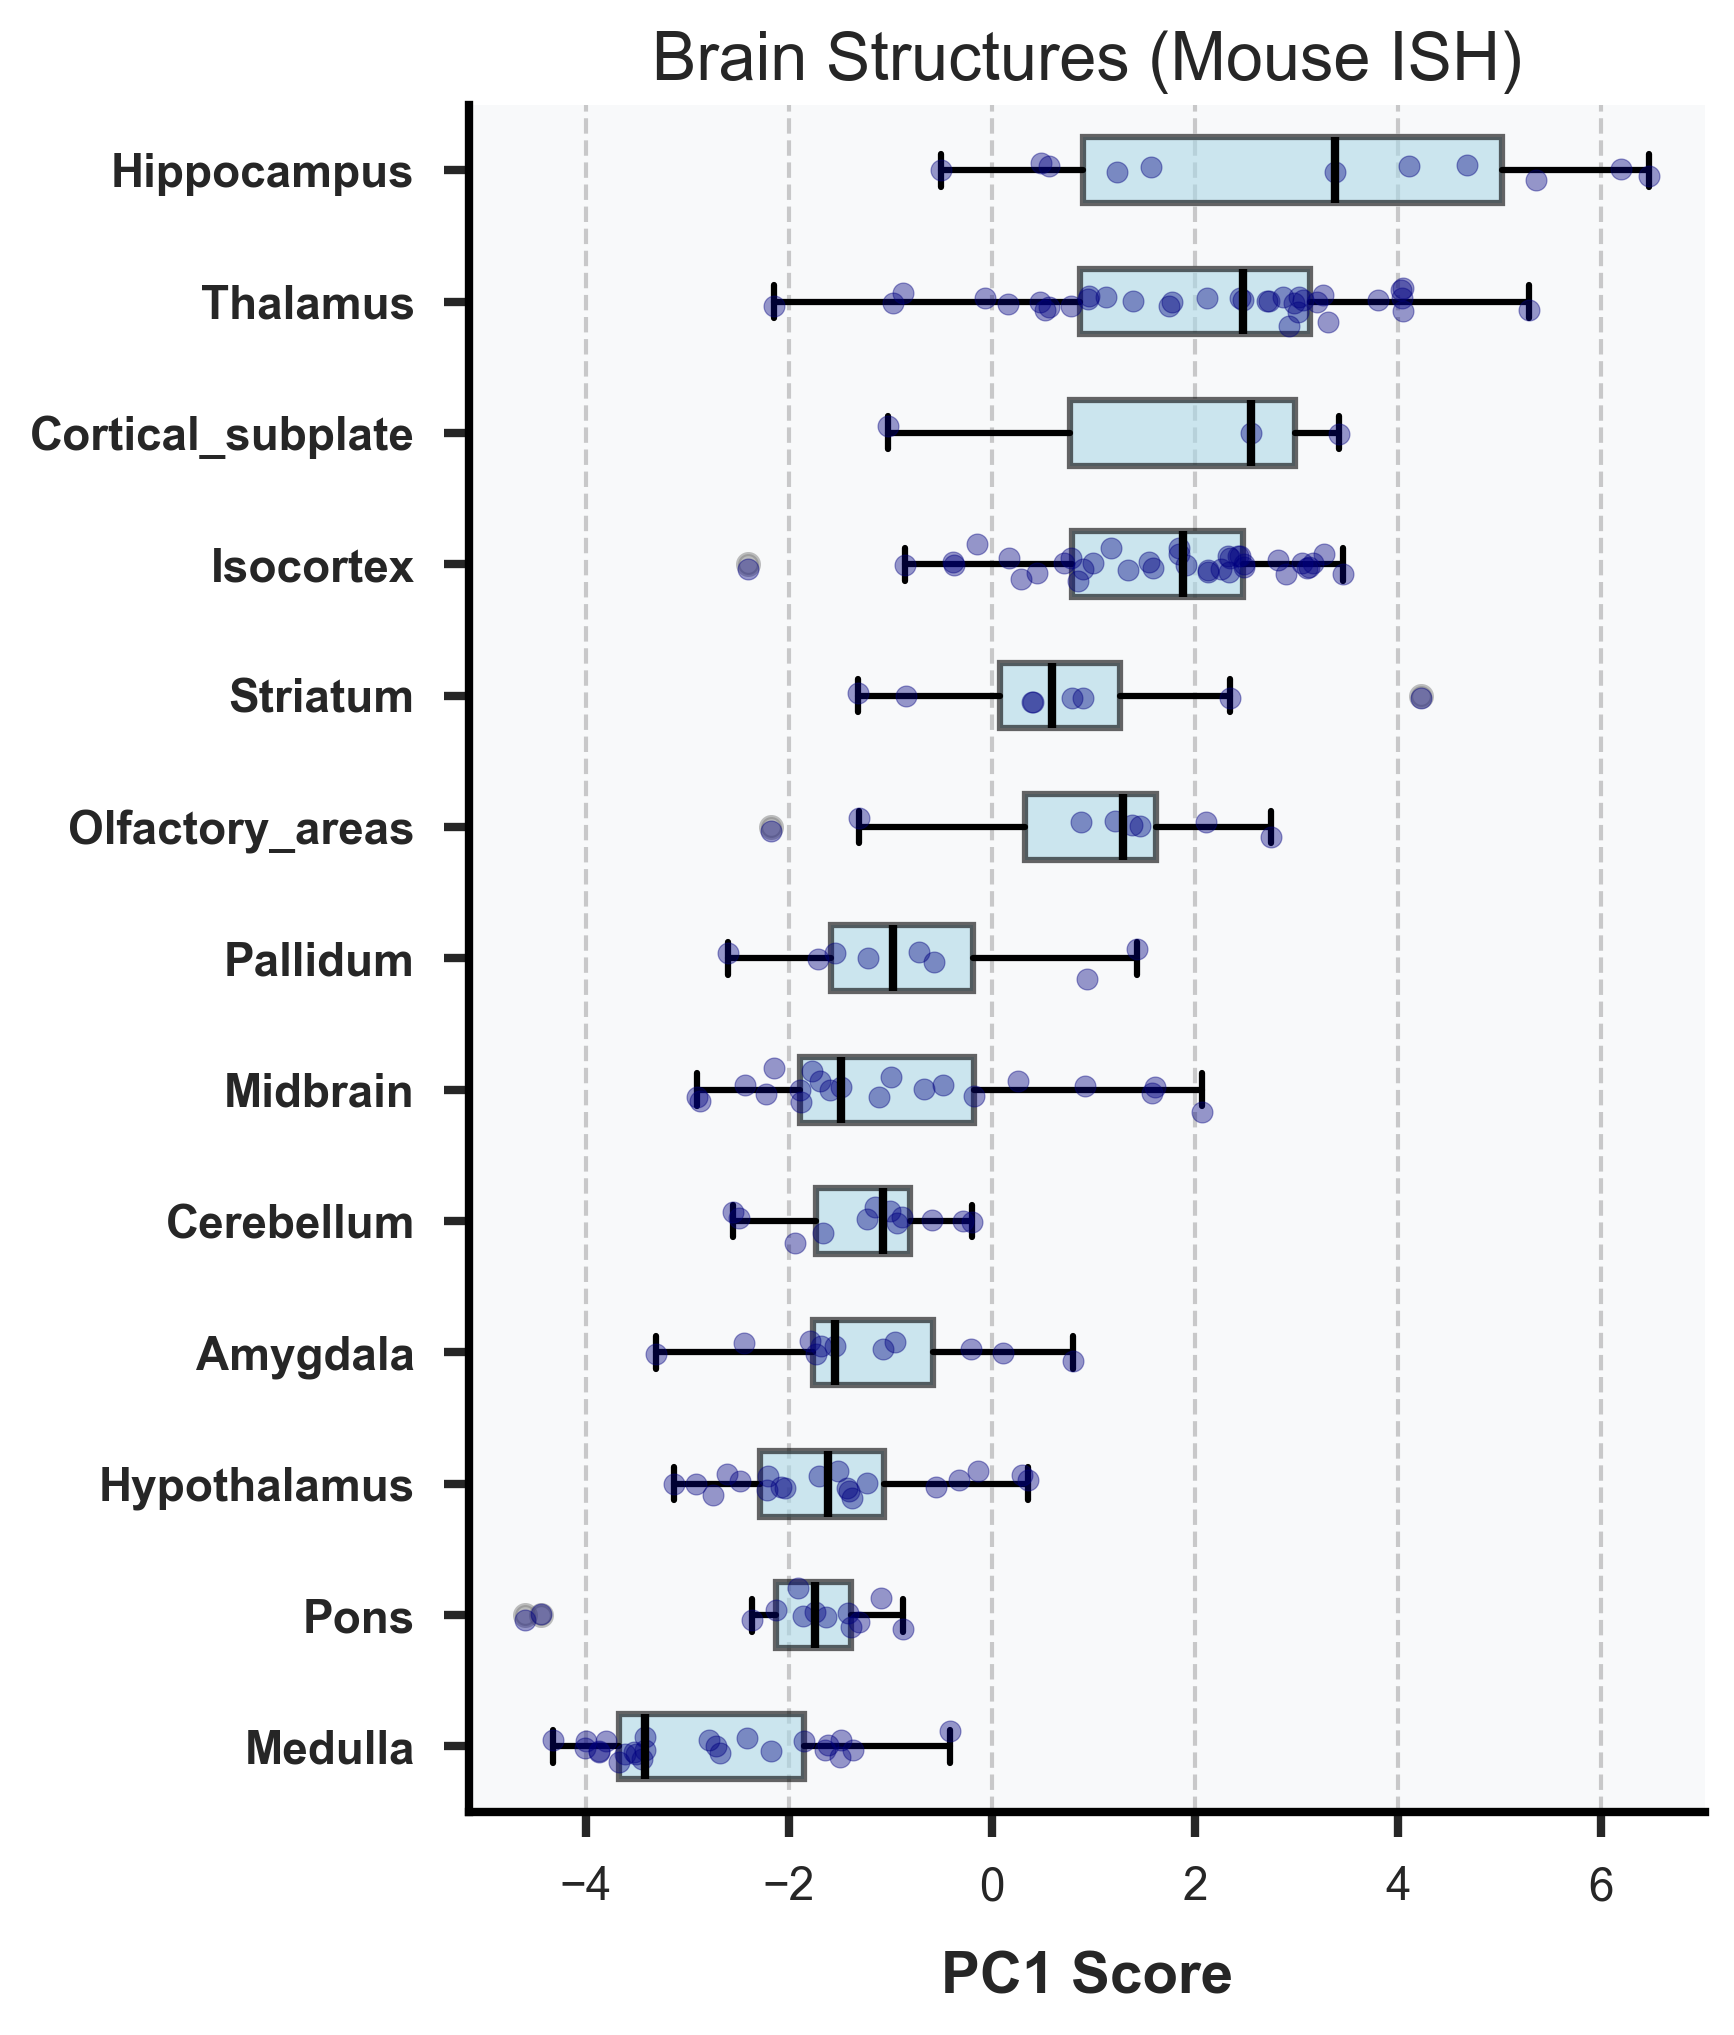

In [40]:
# Plot regional boxplots for PC1 scores
plot_regional_boxplots(pc_scores_df)

PSD vs Total Connection Weights:
Spearman correlation: r = 0.368, p = 3.013e-08


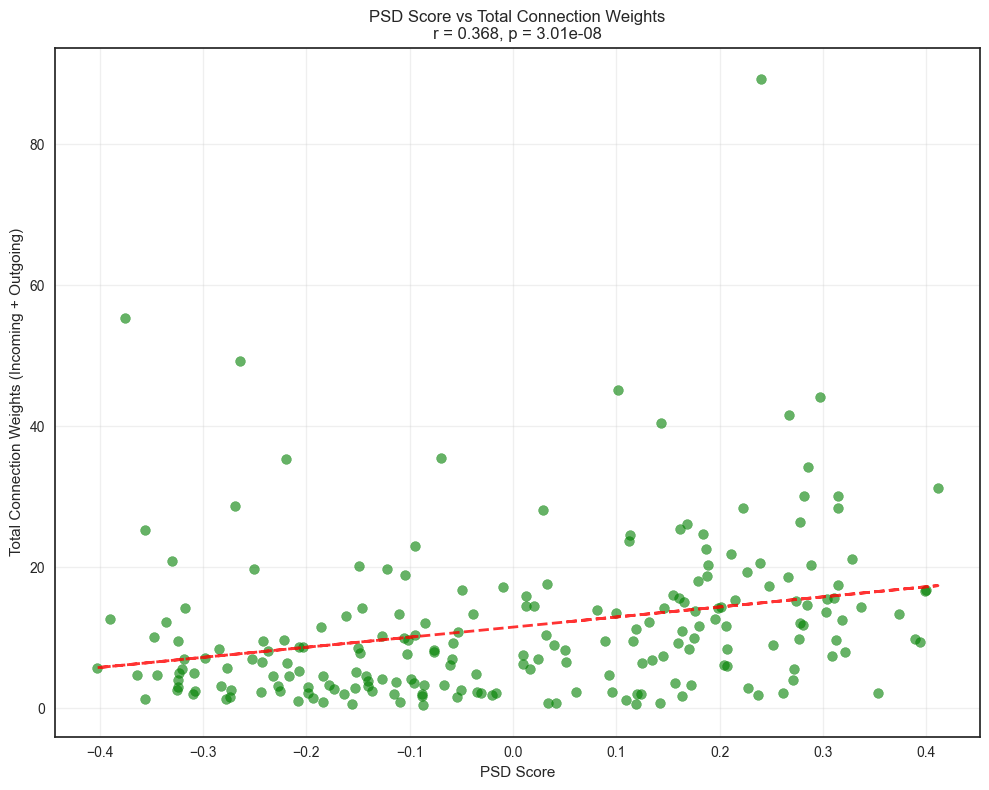


Top 10 structures by PSD score and their connection weights:
                                           PSD  total_all_weights  \
Claustrum                             0.411221          31.291543   
Infralimbic_area                      0.399443          16.810578   
Taenia_tecta                          0.398399          16.634530   
Orbital_area_ventrolateral_part       0.393710           9.337464   
Endopiriform_nucleus_dorsal_part      0.388784           9.743012   
Anterior_cingulate_area_ventral_part  0.373384          13.286609   
Dorsal_peduncular_area                0.353430           2.122479   
Anteromedial_visual_area              0.337023          14.293786   
Endopiriform_nucleus_ventral_part     0.327617          21.171193   
Orbital_area_medial_part              0.321647           7.955229   

                                      total_connections  
Claustrum                                            59  
Infralimbic_area                                     59  
Taen

In [41]:
# Compare PSD vs Total Connection Weights
from scipy import stats

# Calculate correlation between PSD and total connection weights
psd_conn_corr, psd_conn_p = stats.spearmanr(merged_df['PSD'], merged_df['total_all_weights'])

print(f"PSD vs Total Connection Weights:")
print(f"Spearman correlation: r = {psd_conn_corr:.3f}, p = {psd_conn_p:.3e}")

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['PSD'], merged_df['total_all_weights'], alpha=0.6, s=50, color='green')
plt.xlabel('PSD Score')
plt.ylabel('Total Connection Weights (Incoming + Outgoing)')
plt.title(f'PSD Score vs Total Connection Weights\nr = {psd_conn_corr:.3f}, p = {psd_conn_p:.2e}')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(merged_df['PSD'], merged_df['total_all_weights'], 1)
p = np.poly1d(z)
plt.plot(merged_df['PSD'], p(merged_df['PSD']), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# Show top structures by PSD and their connection weights
print("\nTop 10 structures by PSD score and their connection weights:")
psd_sorted = merged_df.sort_values('PSD', ascending=False)
print(psd_sorted[['PSD', 'total_all_weights', 'total_connections']].head(10))

print("\nTop 10 structures by Total Connection Weights and their PSD scores:")
conn_sorted = merged_df.sort_values('total_all_weights', ascending=False)
print(conn_sorted[['PSD', 'total_all_weights', 'total_connections']].head(10))

In [42]:
# Advanced connectivity analysis functions

def calculate_network_metrics(weight_mat):
    """Calculate advanced network metrics for each structure"""
    import networkx as nx
    
    # Create directed graph from weight matrix
    G = nx.from_pandas_adjacency(weight_mat, create_using=nx.DiGraph())
    
    metrics = {}
    
    for node in G.nodes():
        metrics[node] = {
            # Centrality measures
            'out_degree_centrality': G.out_degree(node, weight='weight'),
            'in_degree_centrality': G.in_degree(node, weight='weight'),
            'betweenness_centrality': 0,  # Will calculate separately
            'eigenvector_centrality': 0,  # Will calculate separately
            'pagerank': 0,  # Will calculate separately
            
            # Local connectivity
            'clustering_coefficient': 0,  # Will calculate for undirected version
            'local_efficiency': 0,
            
            # Hub metrics
            'hub_score': 0,
            'authority_score': 0,
            
            # Strength ratios
            'out_in_ratio': 0,
            'participation_coefficient': 0
        }
    
    # Calculate centrality measures (computationally expensive)
    try:
        betweenness = nx.betweenness_centrality(G, weight='weight')
        for node in G.nodes():
            metrics[node]['betweenness_centrality'] = betweenness[node]
    except:
        print("Betweenness centrality calculation failed")
    
    try:
        pagerank = nx.pagerank(G, weight='weight')
        for node in G.nodes():
            metrics[node]['pagerank'] = pagerank[node]
    except:
        print("PageRank calculation failed")
    
    try:
        hubs, authorities = nx.hits(G)
        for node in G.nodes():
            metrics[node]['hub_score'] = hubs[node]
            metrics[node]['authority_score'] = authorities[node]
    except:
        print("HITS algorithm calculation failed")
    
    # Calculate out/in ratio
    for node in G.nodes():
        out_strength = G.out_degree(node, weight='weight')
        in_strength = G.in_degree(node, weight='weight')
        if in_strength > 0:
            metrics[node]['out_in_ratio'] = out_strength / in_strength
        else:
            metrics[node]['out_in_ratio'] = out_strength if out_strength > 0 else 0
    
    return pd.DataFrame.from_dict(metrics, orient='index')

def calculate_connectivity_patterns(weight_mat, merged_df):
    """Analyze connectivity patterns for high vs low PC1/PSD structures"""
    
    # Define high and low groups based on PC1 and PSD
    pc1_high_threshold = merged_df['PC1'].quantile(0.75)
    pc1_low_threshold = merged_df['PC1'].quantile(0.25)
    psd_high_threshold = merged_df['PSD'].quantile(0.75)
    psd_low_threshold = merged_df['PSD'].quantile(0.25)
    
    groups = {
        'PC1_high': merged_df[merged_df['PC1'] >= pc1_high_threshold].index.tolist(),
        'PC1_low': merged_df[merged_df['PC1'] <= pc1_low_threshold].index.tolist(),
        'PSD_high': merged_df[merged_df['PSD'] >= psd_high_threshold].index.tolist(),
        'PSD_low': merged_df[merged_df['PSD'] <= psd_low_threshold].index.tolist()
    }
    
    results = {}
    
    for group_name, structures in groups.items():
        # Filter structures that exist in weight matrix
        valid_structures = [s for s in structures if s in weight_mat.index]
        
        if len(valid_structures) == 0:
            continue
            
        # Calculate within-group connectivity
        within_group_weights = weight_mat.loc[valid_structures, valid_structures]
        within_group_density = (within_group_weights > 0).sum().sum() / (len(valid_structures) ** 2)
        within_group_strength = within_group_weights.sum().sum()
        
        # Calculate connectivity to rest of network
        other_structures = [s for s in weight_mat.index if s not in valid_structures]
        if len(other_structures) > 0:
            to_others = weight_mat.loc[valid_structures, other_structures]
            from_others = weight_mat.loc[other_structures, valid_structures]
            
            outgoing_to_others = to_others.sum().sum()
            incoming_from_others = from_others.sum().sum()
        else:
            outgoing_to_others = 0
            incoming_from_others = 0
        
        results[group_name] = {
            'n_structures': len(valid_structures),
            'within_group_density': within_group_density,
            'within_group_strength': within_group_strength,
            'avg_within_strength': within_group_strength / len(valid_structures) if len(valid_structures) > 0 else 0,
            'outgoing_to_others': outgoing_to_others,
            'incoming_from_others': incoming_from_others,
            'avg_outgoing': outgoing_to_others / len(valid_structures) if len(valid_structures) > 0 else 0,
            'avg_incoming': incoming_from_others / len(valid_structures) if len(valid_structures) > 0 else 0,
            'structures': valid_structures
        }
    
    return results

# Calculate network metrics
print("Calculating advanced network metrics...")
network_metrics_df = calculate_network_metrics(weight_mat)
print(f"Network metrics calculated for {len(network_metrics_df)} structures")

# Merge with existing data
extended_df = merged_df.join(network_metrics_df, how='inner')
print(f"Extended dataset shape: {extended_df.shape}")

Calculating advanced network metrics...
Network metrics calculated for 213 structures
Extended dataset shape: (213, 32)


Correlations with PC1:
----------------------------------------
out_degree_centrality    : r =  0.197, p = 3.854e-03
in_degree_centrality     : r =  0.216, p = 1.550e-03
betweenness_centrality   : r = -0.224, p = 9.700e-04
pagerank                 : r = -0.027, p = 6.977e-01
hub_score                : r =  0.317, p = 2.343e-06
authority_score          : r =  0.403, p = 1.024e-09
out_in_ratio             : r = -0.001, p = 9.862e-01

Correlations with PSD:
----------------------------------------
out_degree_centrality    : r =  0.232, p = 6.552e-04
in_degree_centrality     : r =  0.347, p = 1.985e-07
betweenness_centrality   : r = -0.135, p = 4.866e-02
pagerank                 : r = -0.094, p = 1.738e-01
hub_score                : r =  0.379, p = 1.087e-08
authority_score          : r =  0.512, p = 1.232e-15
out_in_ratio             : r = -0.033, p = 6.344e-01


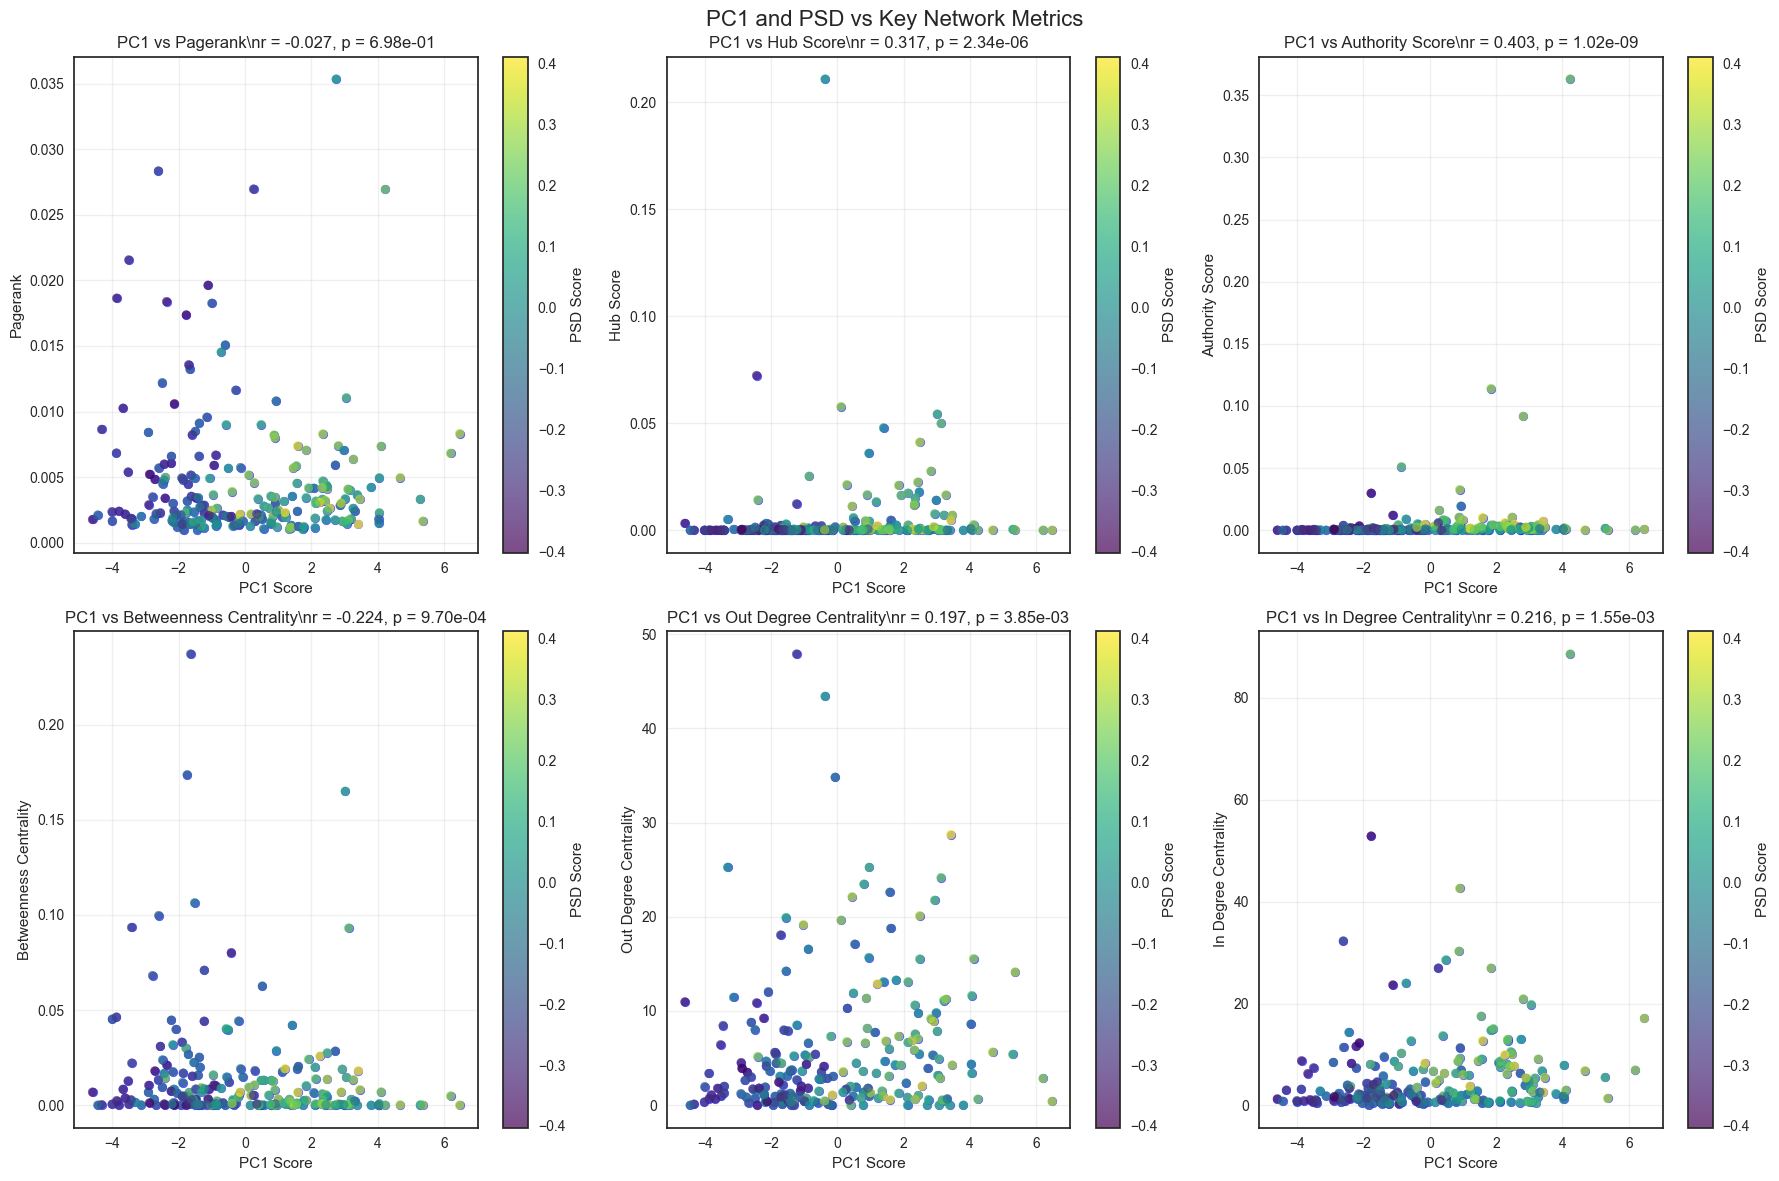

In [43]:
# Correlate PC1/PSD with advanced network metrics
advanced_metrics = ['out_degree_centrality', 'in_degree_centrality', 'betweenness_centrality', 
                   'pagerank', 'hub_score', 'authority_score', 'out_in_ratio']

print("Correlations with PC1:")
print("-" * 40)
for metric in advanced_metrics:
    if metric in extended_df.columns:
        corr, p_val = stats.spearmanr(extended_df['PC1'], extended_df[metric])
        print(f"{metric:25s}: r = {corr:6.3f}, p = {p_val:.3e}")

print("\nCorrelations with PSD:")
print("-" * 40)
for metric in advanced_metrics:
    if metric in extended_df.columns:
        corr, p_val = stats.spearmanr(extended_df['PSD'], extended_df[metric])
        print(f"{metric:25s}: r = {corr:6.3f}, p = {p_val:.3e}")

# Create visualization for strongest correlations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('PC1 and PSD vs Key Network Metrics', fontsize=16)

plot_metrics = ['pagerank', 'hub_score', 'authority_score', 'betweenness_centrality', 'out_degree_centrality', 'in_degree_centrality']

for i, metric in enumerate(plot_metrics):
    if metric not in extended_df.columns:
        continue
        
    row = i // 3
    col = i % 3
    
    # PC1 vs metric
    ax = axes[row, col]
    ax.scatter(extended_df['PC1'], extended_df[metric], alpha=0.6, s=40, color='blue', label='PC1')
    
    # Add PSD as color
    scatter = ax.scatter(extended_df['PC1'], extended_df[metric], 
                        c=extended_df['PSD'], cmap='viridis', alpha=0.7, s=40)
    
    corr_pc1, p_pc1 = stats.spearmanr(extended_df['PC1'], extended_df[metric])
    corr_psd, p_psd = stats.spearmanr(extended_df['PSD'], extended_df[metric])
    
    ax.set_xlabel('PC1 Score')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'PC1 vs {metric.replace("_", " ").title()}\\nr = {corr_pc1:.3f}, p = {p_pc1:.2e}')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar for PSD
    plt.colorbar(scatter, ax=ax, label='PSD Score')

plt.tight_layout()
plt.show()

Connectivity Patterns Analysis
          n_structures  within_group_density  avg_within_strength  \
PC1_high            54              0.138889             3.820785   
PC1_low             54              0.106310             1.612297   
PSD_high            54              0.144719             4.815138   
PSD_low             54              0.155007             2.737859   

          avg_outgoing  avg_incoming  
PC1_high      2.851991      4.335443  
PC1_low       2.119586      3.251724  
PSD_high      2.581089      5.271039  
PSD_low       1.445739      2.145881  
\nGroup Comparisons for Key Metrics:
--------------------------------------------------
\nTOTAL_ALL_WEIGHTS:
  PC1 High vs Low: 12.269 vs 6.364, p = 8.962e-05, effect = 0.518
  PSD High vs Low: 14.964 vs 5.368, p = 5.420e-07, effect = 0.769
\nPAGERANK:
  PC1 High vs Low: 0.003 vs 0.003, p = 8.465e-01, effect = 0.069
  PSD High vs Low: 0.003 vs 0.004, p = 3.519e-01, effect = -0.025
\nHUB_SCORE:
  PC1 High vs Low: 0.000 vs 0.0

/tmp/ipykernel_1781909/1265631825.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data, labels=labels, patch_artist=True)
/tmp/ipykernel_1781909/1265631825.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data, labels=labels, patch_artist=True)
/tmp/ipykernel_1781909/1265631825.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data, labels=labels, patch_artist=True)
/tmp/ipykernel_1781909/1265631825.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for th

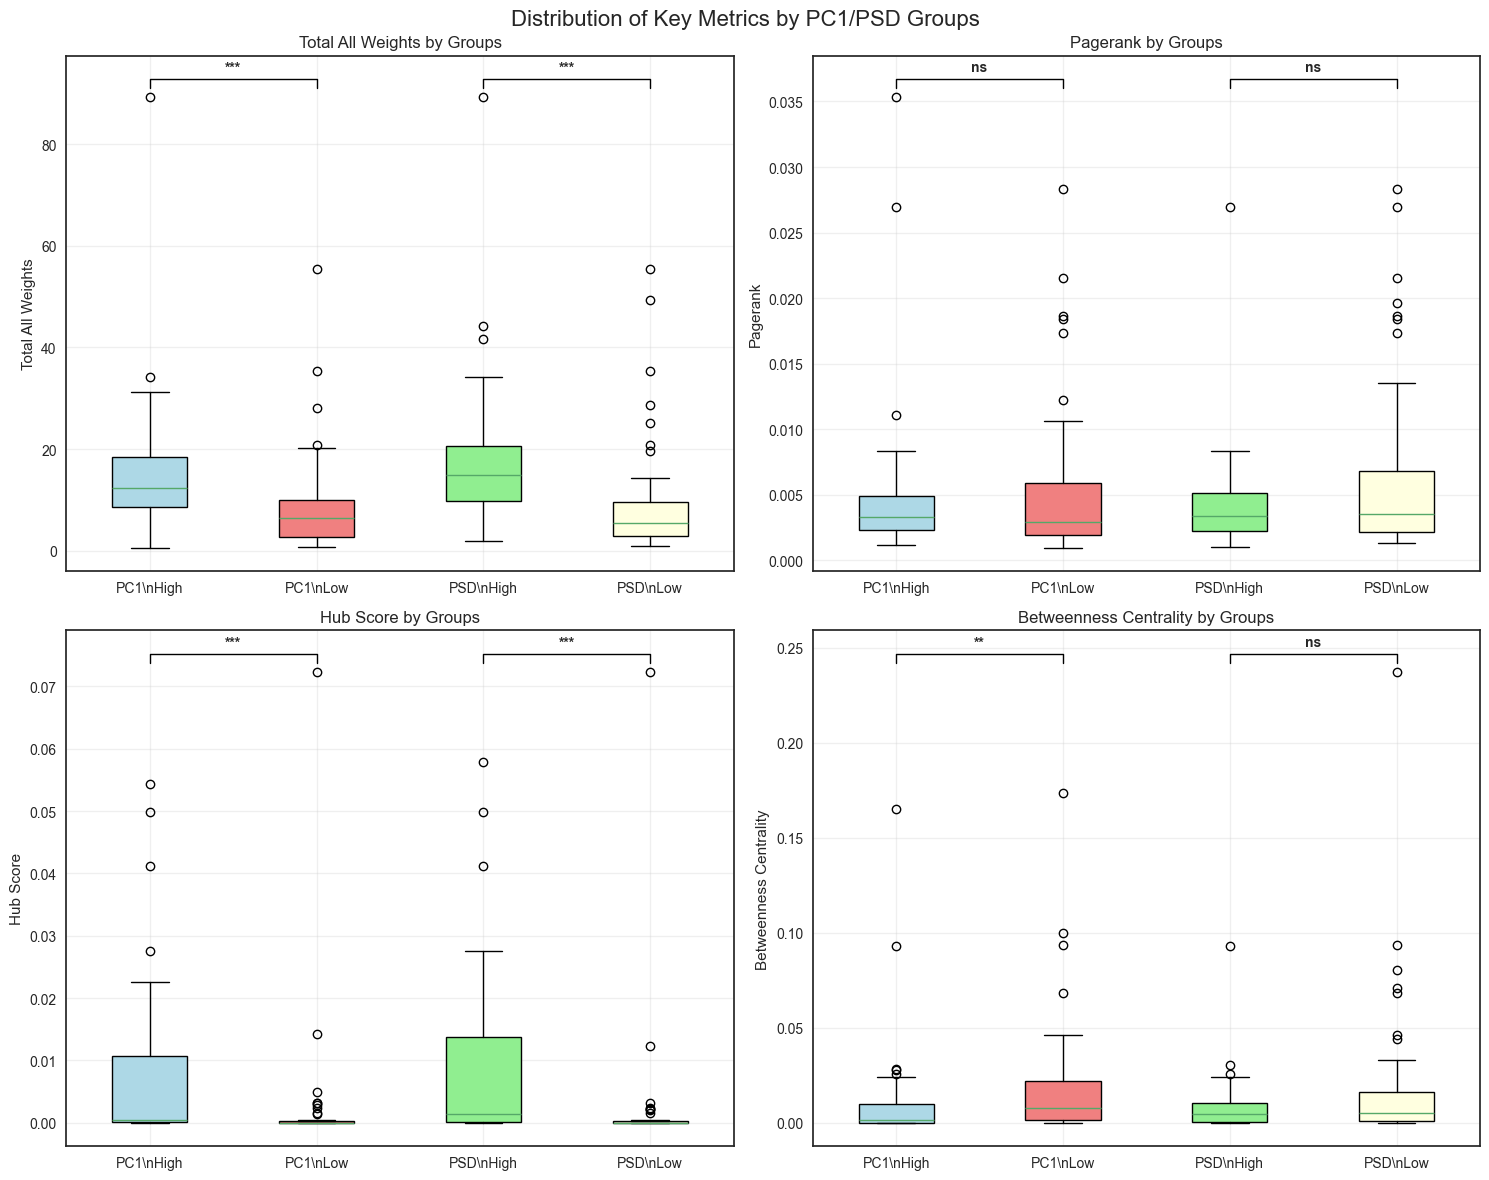

\nSignificance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant


In [46]:
# Analyze connectivity patterns for high vs low PC1/PSD groups
connectivity_patterns = calculate_connectivity_patterns(weight_mat, merged_df)

print("Connectivity Patterns Analysis")
print("=" * 50)

pattern_df = pd.DataFrame.from_dict(connectivity_patterns, orient='index')
print(pattern_df[['n_structures', 'within_group_density', 'avg_within_strength', 
                 'avg_outgoing', 'avg_incoming']])

# Statistical comparisons between groups
from scipy.stats import mannwhitneyu

def compare_groups(df, metric, group1, group2):
    """Compare metric between two groups"""
    group1_structures = connectivity_patterns[group1]['structures']
    group2_structures = connectivity_patterns[group2]['structures']
    
    group1_values = df.loc[group1_structures, metric]
    group2_values = df.loc[group2_structures, metric]
    
    statistic, p_value = mannwhitneyu(group1_values, group2_values, alternative='two-sided')
    
    return {
        'group1_median': group1_values.median(),
        'group2_median': group2_values.median(),
        'statistic': statistic,
        'p_value': p_value,
        'effect_size': (group1_values.median() - group2_values.median()) / 
                      np.sqrt((group1_values.var() + group2_values.var()) / 2)
    }

print("\\nGroup Comparisons for Key Metrics:")
print("-" * 50)

key_metrics = ['total_all_weights', 'pagerank', 'hub_score', 'betweenness_centrality']

# Store comparison results for plotting
comparison_results = {}
for metric in key_metrics:
    if metric in extended_df.columns:
        print(f"\\n{metric.upper()}:")
        
        # PC1 high vs low
        pc1_comparison = compare_groups(extended_df, metric, 'PC1_high', 'PC1_low')
        print(f"  PC1 High vs Low: {pc1_comparison['group1_median']:.3f} vs {pc1_comparison['group2_median']:.3f}, "
              f"p = {pc1_comparison['p_value']:.3e}, effect = {pc1_comparison['effect_size']:.3f}")
        
        # PSD high vs low
        psd_comparison = compare_groups(extended_df, metric, 'PSD_high', 'PSD_low')
        print(f"  PSD High vs Low: {psd_comparison['group1_median']:.3f} vs {psd_comparison['group2_median']:.3f}, "
              f"p = {psd_comparison['p_value']:.3e}, effect = {psd_comparison['effect_size']:.3f}")
        
        comparison_results[metric] = {
            'pc1_p': pc1_comparison['p_value'],
            'psd_p': psd_comparison['p_value']
        }

def add_significance_bar(ax, x1, x2, y, p_value, height_offset=0.05):
    """Add significance bar between two groups"""
    # Determine significance level
    if p_value < 0.001:
        sig_text = '***'
    elif p_value < 0.01:
        sig_text = '**'
    elif p_value < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    # Draw the bar
    bar_height = y + height_offset
    ax.plot([x1, x1, x2, x2], [y, bar_height, bar_height, y], 'k-', linewidth=1)
    
    # Add text
    ax.text((x1 + x2) / 2, bar_height + height_offset/2, sig_text, 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Visualization of group differences with p-value bars
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Key Metrics by PC1/PSD Groups', fontsize=16)

metrics_to_plot = ['total_all_weights', 'pagerank', 'hub_score', 'betweenness_centrality']

for i, metric in enumerate(metrics_to_plot):
    if metric not in extended_df.columns:
        continue
        
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Prepare data for boxplot
    pc1_high = extended_df.loc[connectivity_patterns['PC1_high']['structures'], metric]
    pc1_low = extended_df.loc[connectivity_patterns['PC1_low']['structures'], metric]
    psd_high = extended_df.loc[connectivity_patterns['PSD_high']['structures'], metric]
    psd_low = extended_df.loc[connectivity_patterns['PSD_low']['structures'], metric]
    
    data = [pc1_high, pc1_low, psd_high, psd_low]
    labels = ['PC1\\nHigh', 'PC1\\nLow', 'PSD\\nHigh', 'PSD\\nLow']
    
    box_plot = ax.boxplot(data, labels=labels, patch_artist=True)
    
    # Color boxes
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} by Groups')
    ax.grid(True, alpha=0.3)
    
    # Add significance bars
    if metric in comparison_results:
        # Get the maximum y value for positioning bars
        max_y = max([d.max() for d in data])
        y_range = max_y - min([d.min() for d in data])
        
        # PC1 comparison (positions 1 and 2)
        pc1_p = comparison_results[metric]['pc1_p']
        add_significance_bar(ax, 1, 2, max_y + 0.02 * y_range, pc1_p, 0.02 * y_range)
        
        # PSD comparison (positions 3 and 4)
        psd_p = comparison_results[metric]['psd_p']
        add_significance_bar(ax, 3, 4, max_y + 0.02 * y_range, psd_p, 0.02 * y_range)
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

plt.tight_layout()
plt.show()

# Add legend for significance levels
print("\\nSignificance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")

Rich Club Analysis
PC1 Rich Club Results:
    k  phi_binary  phi_weighted  avg_outgoing_to_others  \
0  10    0.230000      0.127829                4.069660   
1  15    0.142222      0.121678                5.219959   
2  20    0.115000      0.120731                4.792803   
3  25    0.128000      0.134302                4.537521   
4  30    0.116667      0.154215                5.015741   
5  35    0.119184      0.161804                4.297275   
6  40    0.121875      0.185728                4.398329   
7  45    0.131852      0.222752                3.690375   

   avg_incoming_from_others  
0                 11.715463  
1                  8.803494  
2                  7.236007  
3                  6.319110  
4                  5.228610  
5                  5.414320  
6                  4.744956  
7                  4.350729  
\nPSD Rich Club Results:
    k  phi_binary  phi_weighted  avg_outgoing_to_others  \
0  10    0.220000      0.049913                7.592351   
1  15    0.20

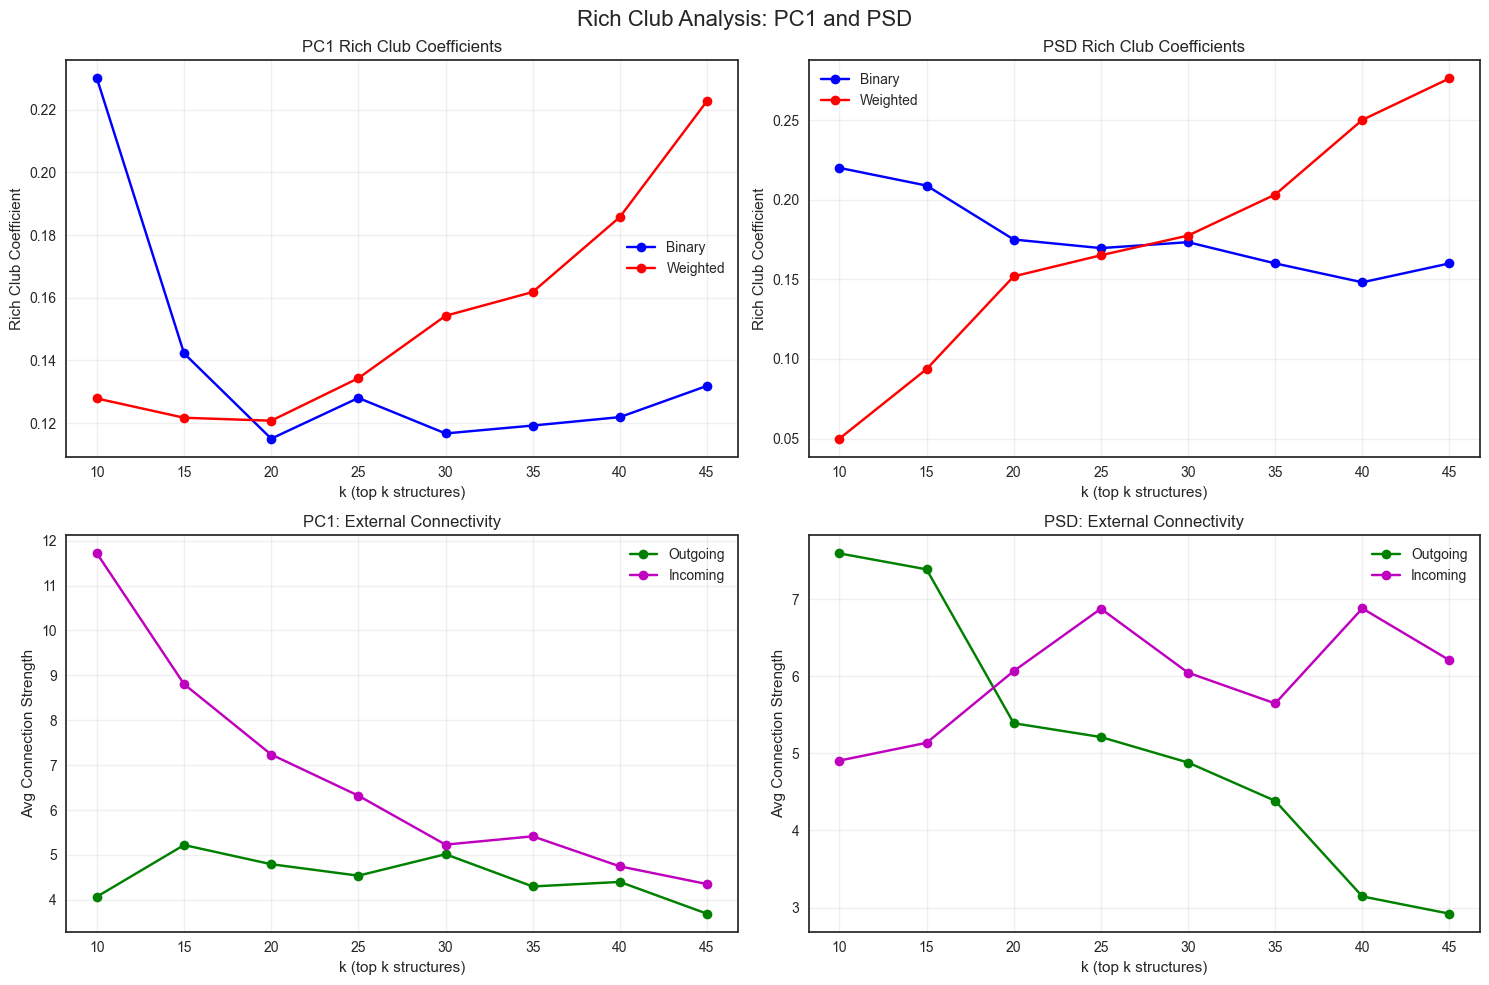

\nTop 15 PC1 structures: ['Field_CA1', 'Dentate_gyrus', 'Field_CA2', 'Lateral_posterior_nucleus_of_the_thalamus', 'Field_CA3', 'Caudoputamen', 'Subiculum_dorsal_part', 'Dorsal_part_of_the_lateral_geniculate_complex', 'Lateral_dorsal_nucleus_of_thalamus', 'Central_lateral_nucleus_of_the_thalamus', 'Ventral_posterolateral_nucleus_of_the_thalamus', 'Parafascicular_nucleus', 'Primary_somatosensory_area_lower_limb', 'Claustrum', 'Presubiculum']
Top 15 PSD structures: ['Claustrum', 'Infralimbic_area', 'Taenia_tecta', 'Orbital_area_ventrolateral_part', 'Endopiriform_nucleus_dorsal_part', 'Anterior_cingulate_area_ventral_part', 'Dorsal_peduncular_area', 'Anteromedial_visual_area', 'Endopiriform_nucleus_ventral_part', 'Orbital_area_medial_part', 'Field_CA3', 'Anterior_cingulate_area_dorsal_part', 'Field_CA1', 'Agranular_insular_area_ventral_part', 'Primary_somatosensory_area_lower_limb']


In [47]:
# Rich Club Analysis - examine if high PC1/PSD structures form a rich club
def rich_club_analysis(weight_mat, score_column, k_values=None):
    """Analyze rich club organization based on PC1/PSD scores"""
    
    if k_values is None:
        k_values = np.arange(10, min(50, len(weight_mat)//2), 5)
    
    results = []
    
    # Sort structures by score (descending)
    sorted_structures = extended_df.sort_values(score_column, ascending=False).index
    
    for k in k_values:
        if k >= len(sorted_structures):
            continue
            
        # Top k structures
        top_k = sorted_structures[:k]
        
        # Calculate rich club coefficient
        # Connections among top k
        top_k_subgraph = weight_mat.loc[top_k, top_k]
        actual_edges = (top_k_subgraph > 0).sum().sum()
        actual_weight = top_k_subgraph.sum().sum()
        
        # Possible connections
        possible_edges = k * k  # including self-connections in directed graph
        
        # Rich club coefficient (binary)
        phi_bin = actual_edges / possible_edges if possible_edges > 0 else 0
        
        # Rich club coefficient (weighted)
        # Take top M edges in the entire network where M = actual_edges
        all_weights_flat = weight_mat.values.flatten()
        all_weights_sorted = np.sort(all_weights_flat[all_weights_flat > 0])[::-1]
        if len(all_weights_sorted) >= actual_edges and actual_edges > 0:
            phi_weighted = actual_weight / all_weights_sorted[:actual_edges].sum()
        else:
            phi_weighted = 0
        
        # Calculate connectivity to rest of network
        other_structures = [s for s in weight_mat.index if s not in top_k]
        if len(other_structures) > 0:
            # Connections from top k to others
            to_others = weight_mat.loc[top_k, other_structures]
            from_others = weight_mat.loc[other_structures, top_k]
            
            avg_outgoing = to_others.sum().sum() / k
            avg_incoming = from_others.sum().sum() / k
            
            # External connectivity ratio
            total_possible_external = k * len(other_structures) * 2  # in and out
            actual_external = (to_others > 0).sum().sum() + (from_others > 0).sum().sum()
            external_ratio = actual_external / total_possible_external if total_possible_external > 0 else 0
        else:
            avg_outgoing = avg_incoming = external_ratio = 0
        
        results.append({
            'k': k,
            'phi_binary': phi_bin,
            'phi_weighted': phi_weighted,
            'avg_outgoing_to_others': avg_outgoing,
            'avg_incoming_from_others': avg_incoming,
            'external_connectivity_ratio': external_ratio,
            'within_group_density': phi_bin,
            'structures': list(top_k)
        })
    
    return pd.DataFrame(results)

# Perform rich club analysis for PC1 and PSD
print("Rich Club Analysis")
print("=" * 50)

pc1_rich_club = rich_club_analysis(weight_mat, 'PC1')
psd_rich_club = rich_club_analysis(weight_mat, 'PSD')

print("PC1 Rich Club Results:")
print(pc1_rich_club[['k', 'phi_binary', 'phi_weighted', 'avg_outgoing_to_others', 'avg_incoming_from_others']])

print("\\nPSD Rich Club Results:")
print(psd_rich_club[['k', 'phi_binary', 'phi_weighted', 'avg_outgoing_to_others', 'avg_incoming_from_others']])

# Visualize rich club organization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Rich Club Analysis: PC1 and PSD', fontsize=16)

# PC1 rich club coefficients
axes[0,0].plot(pc1_rich_club['k'], pc1_rich_club['phi_binary'], 'bo-', label='Binary')
axes[0,0].plot(pc1_rich_club['k'], pc1_rich_club['phi_weighted'], 'ro-', label='Weighted')
axes[0,0].set_xlabel('k (top k structures)')
axes[0,0].set_ylabel('Rich Club Coefficient')
axes[0,0].set_title('PC1 Rich Club Coefficients')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# PSD rich club coefficients
axes[0,1].plot(psd_rich_club['k'], psd_rich_club['phi_binary'], 'bo-', label='Binary')
axes[0,1].plot(psd_rich_club['k'], psd_rich_club['phi_weighted'], 'ro-', label='Weighted')
axes[0,1].set_xlabel('k (top k structures)')
axes[0,1].set_ylabel('Rich Club Coefficient')
axes[0,1].set_title('PSD Rich Club Coefficients')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# External connectivity
axes[1,0].plot(pc1_rich_club['k'], pc1_rich_club['avg_outgoing_to_others'], 'go-', label='Outgoing')
axes[1,0].plot(pc1_rich_club['k'], pc1_rich_club['avg_incoming_from_others'], 'mo-', label='Incoming')
axes[1,0].set_xlabel('k (top k structures)')
axes[1,0].set_ylabel('Avg Connection Strength')
axes[1,0].set_title('PC1: External Connectivity')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(psd_rich_club['k'], psd_rich_club['avg_outgoing_to_others'], 'go-', label='Outgoing')
axes[1,1].plot(psd_rich_club['k'], psd_rich_club['avg_incoming_from_others'], 'mo-', label='Incoming')
axes[1,1].set_xlabel('k (top k structures)')
axes[1,1].set_ylabel('Avg Connection Strength')
axes[1,1].set_title('PSD: External Connectivity')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show which structures are in the top rich clubs
print(f"\\nTop 15 PC1 structures: {pc1_rich_club[pc1_rich_club['k']==15]['structures'].iloc[0] if len(pc1_rich_club[pc1_rich_club['k']==15]) > 0 else 'N/A'}")
print(f"Top 15 PSD structures: {psd_rich_club[psd_rich_club['k']==15]['structures'].iloc[0] if len(psd_rich_club[psd_rich_club['k']==15]) > 0 else 'N/A'}")

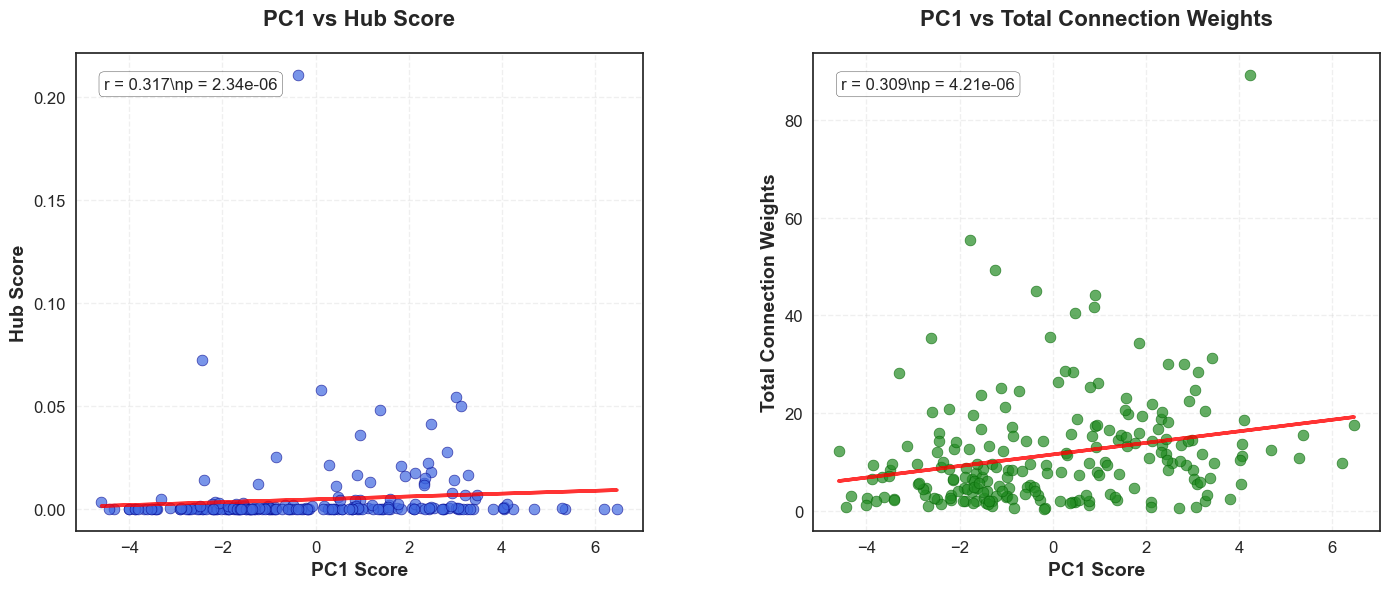

Correlation Results:
PC1 vs Hub Score: r = 0.317, p = 2.343e-06
PC1 vs Total Weights: r = 0.309, p = 4.215e-06


'\n# Single plot version - Hub Score only\nplt.figure(figsize=(8, 6))\nplt.scatter(extended_df[\'PC1\'], extended_df[\'hub_score\'], \n           s=MARKER_SIZE, alpha=MARKER_ALPHA, color=\'royalblue\', \n           edgecolors=\'darkblue\', linewidth=0.5)\nz = np.polyfit(extended_df[\'PC1\'], extended_df[\'hub_score\'], 1)\np = np.poly1d(z)\nplt.plot(extended_df[\'PC1\'], p(extended_df[\'PC1\']), "r-", alpha=0.8, linewidth=2.5)\nplt.xlabel(\'PC1 Score\', fontsize=FONTSIZE_LABEL, fontweight=\'bold\')\nplt.ylabel(\'Hub Score\', fontsize=FONTSIZE_LABEL, fontweight=\'bold\')\nplt.title(\'PC1 vs Hub Score\', fontsize=FONTSIZE_TITLE, fontweight=\'bold\')\nplt.grid(True, alpha=GRID_ALPHA, linestyle=\'--\')\ncorr_text = f\'r = {hub_pc1_corr:.3f}, p = {hub_pc1_p:.2e}\'\nplt.text(0.05, 0.95, corr_text, transform=plt.gca().transAxes, fontsize=FONTSIZE_CORR,\n         verticalalignment=\'top\', bbox=dict(boxstyle=\'round\', facecolor=\'white\', alpha=0.8))\nplt.tight_layout()\nplt.show()\n'

In [48]:
# Poster-ready plots: Hub Score and Total Weights vs PC1
from scipy import stats

# Calculate correlations
hub_pc1_corr, hub_pc1_p = stats.spearmanr(extended_df['PC1'], extended_df['hub_score'])
weights_pc1_corr, weights_pc1_p = stats.spearmanr(extended_df['PC1'], extended_df['total_all_weights'])

# Create publication-ready figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Customizable plot parameters for poster
FONTSIZE_TITLE = 16
FONTSIZE_LABEL = 14
FONTSIZE_TICK = 12
FONTSIZE_CORR = 12
MARKER_SIZE = 60
MARKER_ALPHA = 0.7
GRID_ALPHA = 0.3
DPI = 300

# Plot 1: PC1 vs Hub Score
ax1 = axes[0]
scatter1 = ax1.scatter(extended_df['PC1'], extended_df['hub_score'], 
                      s=MARKER_SIZE, alpha=MARKER_ALPHA, color='royalblue', 
                      edgecolors='darkblue', linewidth=0.5)

# Add trend line
z1 = np.polyfit(extended_df['PC1'], extended_df['hub_score'], 1)
p1 = np.poly1d(z1)
ax1.plot(extended_df['PC1'], p1(extended_df['PC1']), "r-", alpha=0.8, linewidth=2.5)

ax1.set_xlabel('PC1 Score', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax1.set_ylabel('Hub Score', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax1.set_title('PC1 vs Hub Score', fontsize=FONTSIZE_TITLE, fontweight='bold', pad=20)
ax1.grid(True, alpha=GRID_ALPHA, linestyle='--')

# Add correlation text box
corr_text1 = f'r = {hub_pc1_corr:.3f}\\np = {hub_pc1_p:.2e}'
ax1.text(0.05, 0.95, corr_text1, transform=ax1.transAxes, fontsize=FONTSIZE_CORR,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize ticks
ax1.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK)

# Plot 2: PC1 vs Total Connection Weights
ax2 = axes[1]
scatter2 = ax2.scatter(extended_df['PC1'], extended_df['total_all_weights'], 
                      s=MARKER_SIZE, alpha=MARKER_ALPHA, color='forestgreen', 
                      edgecolors='darkgreen', linewidth=0.5)

# Add trend line
z2 = np.polyfit(extended_df['PC1'], extended_df['total_all_weights'], 1)
p2 = np.poly1d(z2)
ax2.plot(extended_df['PC1'], p2(extended_df['PC1']), "r-", alpha=0.8, linewidth=2.5)

ax2.set_xlabel('PC1 Score', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax2.set_ylabel('Total Connection Weights', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax2.set_title('PC1 vs Total Connection Weights', fontsize=FONTSIZE_TITLE, fontweight='bold', pad=20)
ax2.grid(True, alpha=GRID_ALPHA, linestyle='--')

# Add correlation text box
corr_text2 = f'r = {weights_pc1_corr:.3f}\\np = {weights_pc1_p:.2e}'
ax2.text(0.05, 0.95, corr_text2, transform=ax2.transAxes, fontsize=FONTSIZE_CORR,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Customize ticks
ax2.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK)

# Adjust layout and save
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

# Display the plot
plt.show()

# Print correlation results for reference
print("Correlation Results:")
print(f"PC1 vs Hub Score: r = {hub_pc1_corr:.3f}, p = {hub_pc1_p:.3e}")
print(f"PC1 vs Total Weights: r = {weights_pc1_corr:.3f}, p = {weights_pc1_p:.3e}")

# Optional: Save high-resolution figure for poster
# Uncomment the lines below to save the figure
# plt.savefig('PC1_connectivity_poster.png', dpi=DPI, bbox_inches='tight', 
#             facecolor='white', edgecolor='none')
# plt.savefig('PC1_connectivity_poster.pdf', bbox_inches='tight', 
#             facecolor='white', edgecolor='none')

# Alternative single-plot versions (uncomment to use)
"""
# Single plot version - Hub Score only
plt.figure(figsize=(8, 6))
plt.scatter(extended_df['PC1'], extended_df['hub_score'], 
           s=MARKER_SIZE, alpha=MARKER_ALPHA, color='royalblue', 
           edgecolors='darkblue', linewidth=0.5)
z = np.polyfit(extended_df['PC1'], extended_df['hub_score'], 1)
p = np.poly1d(z)
plt.plot(extended_df['PC1'], p(extended_df['PC1']), "r-", alpha=0.8, linewidth=2.5)
plt.xlabel('PC1 Score', fontsize=FONTSIZE_LABEL, fontweight='bold')
plt.ylabel('Hub Score', fontsize=FONTSIZE_LABEL, fontweight='bold')
plt.title('PC1 vs Hub Score', fontsize=FONTSIZE_TITLE, fontweight='bold')
plt.grid(True, alpha=GRID_ALPHA, linestyle='--')
corr_text = f'r = {hub_pc1_corr:.3f}, p = {hub_pc1_p:.2e}'
plt.text(0.05, 0.95, corr_text, transform=plt.gca().transAxes, fontsize=FONTSIZE_CORR,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()
"""

PC1 High vs Low Group Comparisons:
Hub Score:
  PC1 High (n=107): median = 0.000, mean = 0.006
  PC1 Low (n=106): median = 0.000, mean = 0.004
  Mann-Whitney U: p = 6.561e-06, effect size (Cohen's d) = 0.130
\nTotal Connection Weights:
  PC1 High (n=107): median = 11.784, mean = 14.069
  PC1 Low (n=106): median = 6.119, mean = 8.986
  Mann-Whitney U: p = 3.195e-05, effect size (Cohen's d) = 0.464


/tmp/ipykernel_1781909/521383856.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box1 = ax1.boxplot(data1, labels=labels1, patch_artist=True, widths=BOX_WIDTH,
/tmp/ipykernel_1781909/521383856.py:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box2 = ax2.boxplot(data2, labels=labels2, patch_artist=True, widths=BOX_WIDTH,


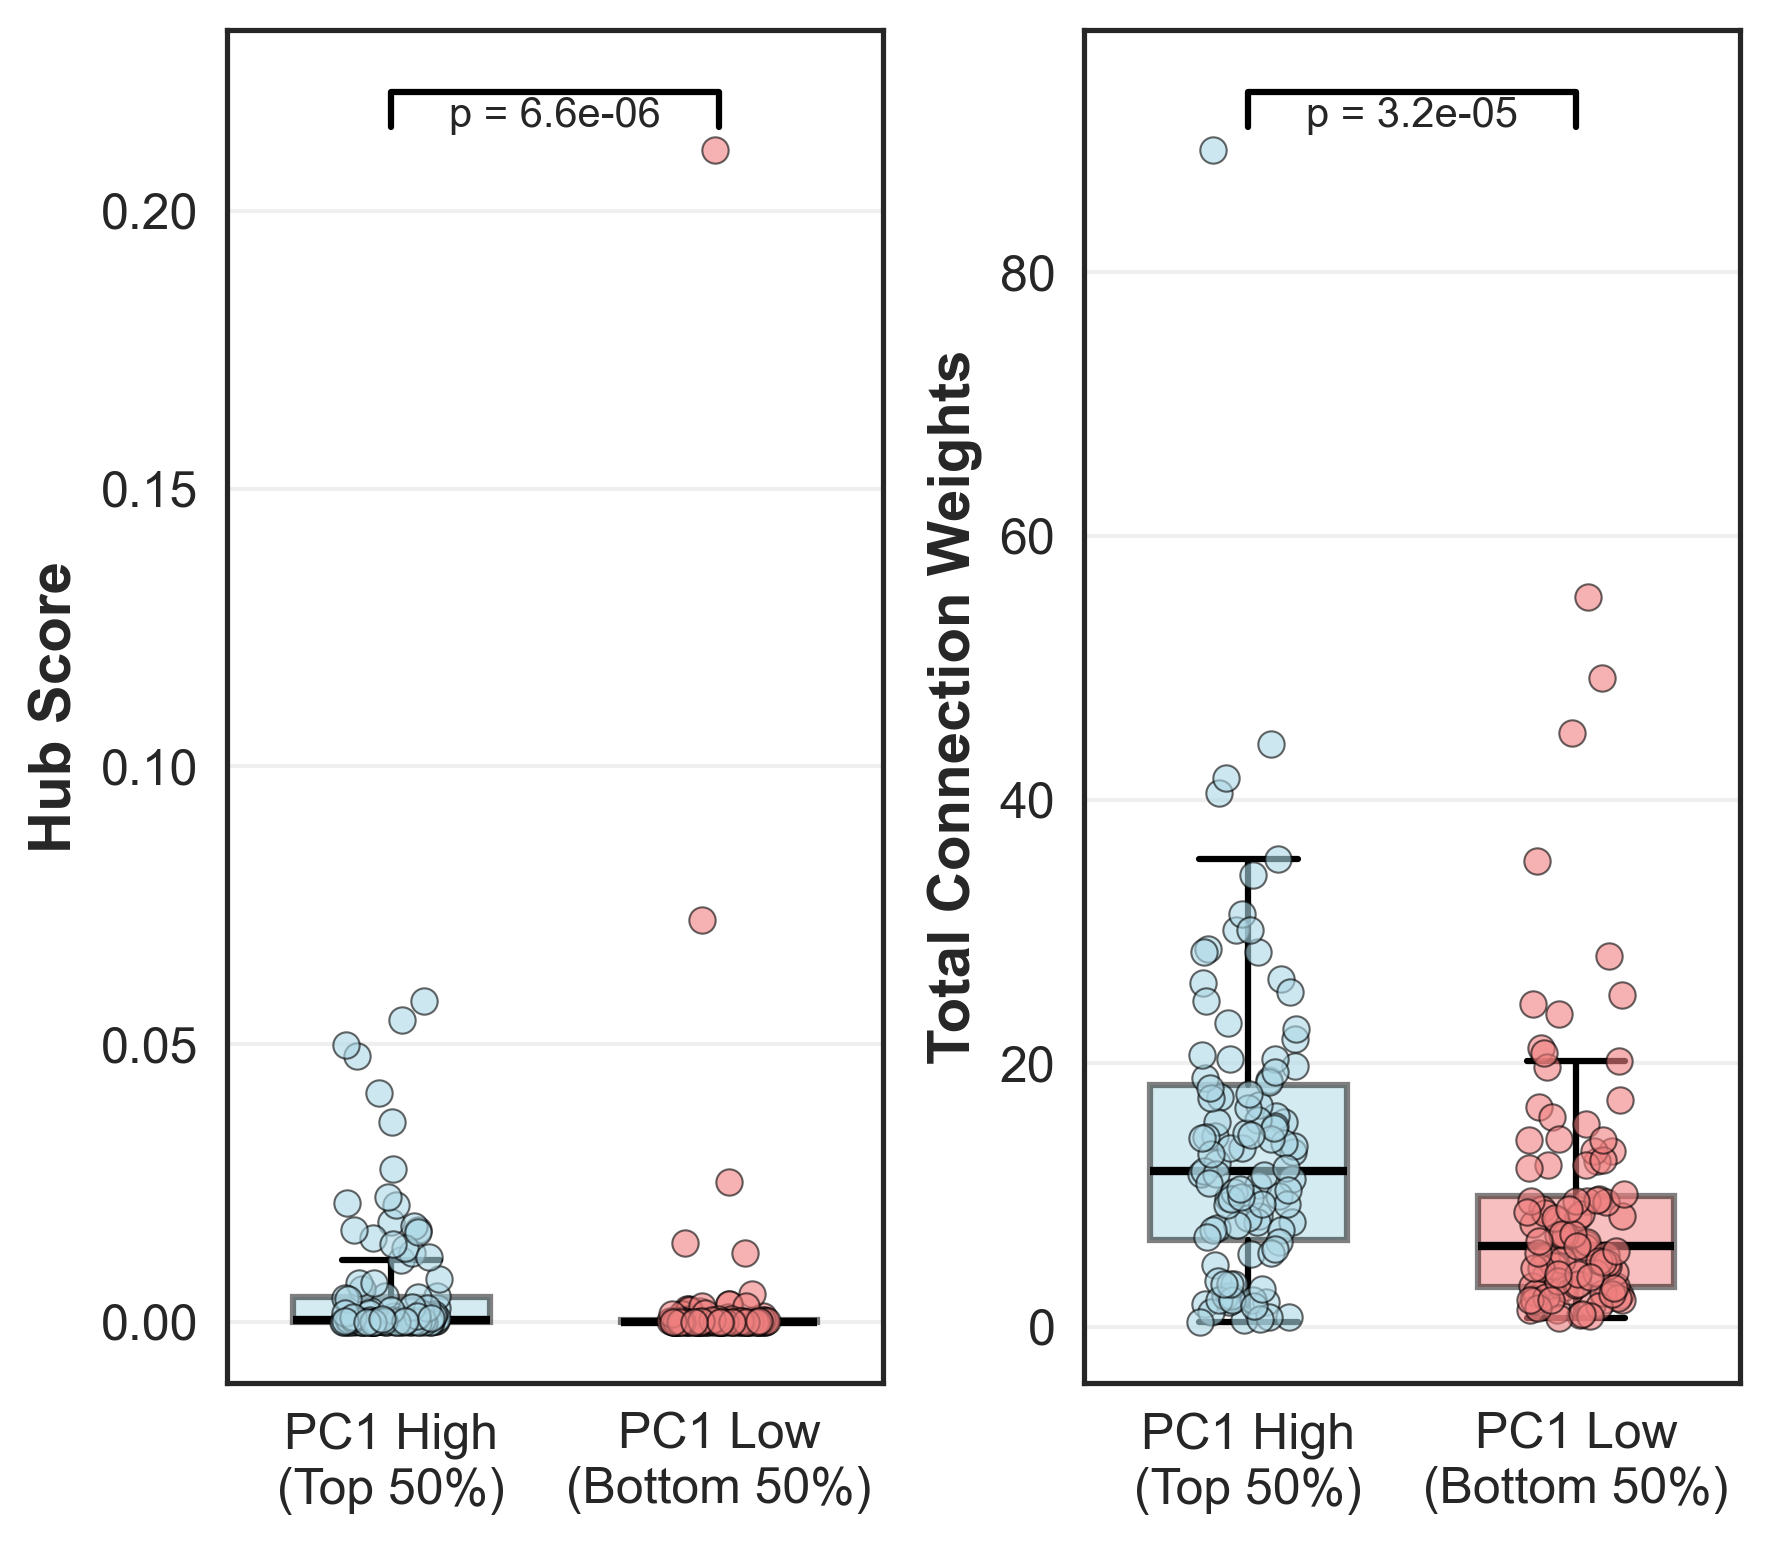

\nSummary Statistics:
                     Metric  PC1_High_Mean  PC1_Low_Mean   P_Value  \
0                 Hub Score       0.005826      0.003553  0.000007   
1  Total Connection Weights      14.068803      8.985624  0.000032   

   Effect_Size  Fold_Change  
0     0.129648     1.639764  
1     0.463559     1.565701  
\nSignificance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant
Effect size interpretation: small (0.2), medium (0.5), large (0.8)
\nIndividual data points are shown with jitter for visibility


In [ ]:
# Binarized analysis: PC1 High vs Low for Hub Score and Connection Weights
from scipy.stats import mannwhitneyu, ttest_ind
import seaborn as sns

# Define PC1 high and low groups (top and bottom 50%)
pc1_median = extended_df['PC1'].median()

pc1_high_mask = extended_df['PC1'] >= pc1_median
pc1_low_mask = extended_df['PC1'] < pc1_median

# Extract data for each group
pc1_high_hub = extended_df.loc[pc1_high_mask, 'hub_score']
pc1_low_hub = extended_df.loc[pc1_low_mask, 'hub_score']
pc1_high_weights = extended_df.loc[pc1_high_mask, 'total_all_weights']
pc1_low_weights = extended_df.loc[pc1_low_mask, 'total_all_weights']

# Statistical tests
hub_stat, hub_p = mannwhitneyu(pc1_high_hub, pc1_low_hub, alternative='two-sided')
weights_stat, weights_p = mannwhitneyu(pc1_high_weights, pc1_low_weights, alternative='two-sided')

# Calculate effect sizes (Cohen's d)
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(), group2.std()
    pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

hub_effect_size = cohens_d(pc1_high_hub, pc1_low_hub)
weights_effect_size = cohens_d(pc1_high_weights, pc1_low_weights)

print("PC1 High vs Low Group Comparisons:")
print("=" * 50)
print(f"Hub Score:")
print(f"  PC1 High (n={len(pc1_high_hub)}): median = {pc1_high_hub.median():.3f}, mean = {pc1_high_hub.mean():.3f}")
print(f"  PC1 Low (n={len(pc1_low_hub)}): median = {pc1_low_hub.median():.3f}, mean = {pc1_low_hub.mean():.3f}")
print(f"  Mann-Whitney U: p = {hub_p:.3e}, effect size (Cohen's d) = {hub_effect_size:.3f}")

print(f"\\nTotal Connection Weights:")
print(f"  PC1 High (n={len(pc1_high_weights)}): median = {pc1_high_weights.median():.3f}, mean = {pc1_high_weights.mean():.3f}")
print(f"  PC1 Low (n={len(pc1_low_weights)}): median = {pc1_low_weights.median():.3f}, mean = {pc1_low_weights.mean():.3f}")
print(f"  Mann-Whitney U: p = {weights_p:.3e}, effect size (Cohen's d) = {weights_effect_size:.3f}")

# Create publication-ready boxplots with individual data points
fig, axes = plt.subplots(1, 2, figsize=(8, 6), dpi=300)

# Customizable parameters
FONTSIZE_TITLE = 16
FONTSIZE_LABEL = 14
FONTSIZE_TICK = 12
FONTSIZE_STATS = 12
BOX_WIDTH = 0.6
COLORS = ['lightblue', 'lightcoral']

# Individual point parameters
POINT_SIZE = 40
POINT_ALPHA = 0.6
JITTER_WIDTH = 0.15

def add_significance_annotation(ax, x1, x2, y, p_value, height_offset=0.05):
    """Add significance annotation between groups"""
    if p_value < 0.001:
        sig_text = '***'
    elif p_value < 0.01:
        sig_text = '**'
    elif p_value < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    # Draw the bar
    bar_height = y + height_offset
    ax.plot([x1, x1, x2, x2], [y, bar_height, bar_height, y], 'k-', linewidth=1.5)
    
    # Add significance text
    # ax.text((x1 + x2) / 2, bar_height + height_offset/3, sig_text, 
    #         ha='center', va='bottom', fontsize=FONTSIZE_STATS, fontweight='bold')
    
    # Add p-value
    ax.text((x1 + x2) / 2, bar_height + height_offset/3 - height_offset/2, 
            f'p = {p_value:.1e}', ha='center', va='top', fontsize=FONTSIZE_STATS-2)

def add_jittered_points(ax, x_pos, data, color, jitter_width=JITTER_WIDTH):
    """Add jittered individual data points"""
    np.random.seed(42)  # For reproducible jitter
    jitter = np.random.uniform(-jitter_width, jitter_width, len(data))
    x_jittered = x_pos + jitter
    ax.scatter(x_jittered, data, s=POINT_SIZE, alpha=POINT_ALPHA, 
               color=color, edgecolors='black', linewidth=0.5, zorder=3)

# Plot 1: Hub Score
ax1 = axes[0]
data1 = [pc1_high_hub, pc1_low_hub]
labels1 = ['PC1 High\n(Top 50%)', 'PC1 Low\n(Bottom 50%)']

box1 = ax1.boxplot(data1, labels=labels1, patch_artist=True, widths=BOX_WIDTH,
                   medianprops=dict(color='black', linewidth=2),
                   boxprops=dict(linewidth=1.5),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5),
                   showfliers=False)  # Hide outliers since we're showing all points

# Color the boxes
for patch, color in zip(box1['boxes'], COLORS):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)  # Make boxes more transparent to see points

# Add individual data points
add_jittered_points(ax1, 1, pc1_high_hub, COLORS[0])
add_jittered_points(ax1, 2, pc1_low_hub, COLORS[1])

ax1.set_ylabel('Hub Score', fontsize=FONTSIZE_LABEL, fontweight='bold')
#ax1.set_title('Hub Score by PC1 Groups', fontsize=FONTSIZE_TITLE, fontweight='bold', pad=30)
ax1.grid(True, alpha=0.3, axis='y', zorder=0)
ax1.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK)

# Add significance annotation
max_y1 = max(pc1_high_hub.max(), pc1_low_hub.max())
y_range1 = max_y1 - min(pc1_high_hub.min(), pc1_low_hub.min())
add_significance_annotation(ax1, 1, 2, max_y1 + 0.02 * y_range1, hub_p, 0.03 * y_range1)

# # Add effect size annotation
# ax1.text(0.02, 0.98, f"Cohen's d = {hub_effect_size:.3f}", 
#          transform=ax1.transAxes, fontsize=FONTSIZE_STATS,
#          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Total Connection Weights
ax2 = axes[1]
data2 = [pc1_high_weights, pc1_low_weights]
labels2 = ['PC1 High\n(Top 50%)', 'PC1 Low\n(Bottom 50%)']

box2 = ax2.boxplot(data2, labels=labels2, patch_artist=True, widths=BOX_WIDTH,
                   medianprops=dict(color='black', linewidth=2),
                   boxprops=dict(linewidth=1.5),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5),
                   showfliers=False)  # Hide outliers since we're showing all points

# Color the boxes
for patch, color in zip(box2['boxes'], COLORS):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)  # Make boxes more transparent to see points

# Add individual data points
add_jittered_points(ax2, 1, pc1_high_weights, COLORS[0])
add_jittered_points(ax2, 2, pc1_low_weights, COLORS[1])

ax2.set_ylabel('Total Connection Weights', fontsize=FONTSIZE_LABEL, fontweight='bold')
#ax2.set_title('Connection Weights by PC1 Groups', fontsize=FONTSIZE_TITLE, fontweight='bold', pad=30)
ax2.grid(True, alpha=0.3, axis='y', zorder=0)
ax2.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK)

# Add significance annotation
max_y2 = max(pc1_high_weights.max(), pc1_low_weights.max())
y_range2 = max_y2 - min(pc1_high_weights.min(), pc1_low_weights.min())
add_significance_annotation(ax2, 1, 2, max_y2 + 0.02 * y_range2, weights_p, 0.03 * y_range2)

# # Add effect size annotation
# ax2.text(0.02, 0.98, f"Cohen's d = {weights_effect_size:.3f}", 
#          transform=ax2.transAxes, fontsize=FONTSIZE_STATS,
#          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add note about individual points
#fig.suptitle('PC1 Group Comparisons with Individual Data Points', fontsize=FONTSIZE_TITLE+2, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust for suptitle
plt.show()

# Summary statistics table
print("\\nSummary Statistics:")
print("=" * 50)
summary_data = {
    'Metric': ['Hub Score', 'Total Connection Weights'],
    'PC1_High_Mean': [pc1_high_hub.mean(), pc1_high_weights.mean()],
    'PC1_Low_Mean': [pc1_low_hub.mean(), pc1_low_weights.mean()],
    'P_Value': [hub_p, weights_p],
    'Effect_Size': [hub_effect_size, weights_effect_size],
    'Fold_Change': [pc1_high_hub.mean()/pc1_low_hub.mean(), pc1_high_weights.mean()/pc1_low_weights.mean()]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)

print("\\nSignificance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
print("Effect size interpretation: small (0.2), medium (0.5), large (0.8)")
print(f"\\nIndividual data points are shown with jitter for visibility")

# Optional: Save the figure
# plt.savefig('PC1_binarized_comparison_with_points.png', dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none')
# plt.savefig('PC1_binarized_comparison_with_points.pdf', bbox_inches='tight', 
#             facecolor='white', edgecolor='none')

PC1 High vs Low Group Comparisons:
Hub Score:
  PC1 High (n=54): median = 0.000, mean = 0.007
  PC1 Low (n=54): median = 0.000, mean = 0.002
  Mann-Whitney U: p = 1.714e-04, effect size (Cohen's d) = 0.439
\nTotal Connection Weights:
  PC1 High (n=54): median = 12.269, mean = 14.829
  PC1 Low (n=54): median = 6.364, mean = 8.596
  Mann-Whitney U: p = 8.962e-05, effect size (Cohen's d) = 0.546


/tmp/ipykernel_1781909/3844181507.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=hub_data, x='Group', y='Hub Score',
/tmp/ipykernel_1781909/3844181507.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=weights_data, x='Group', y='Total Connection Weights',


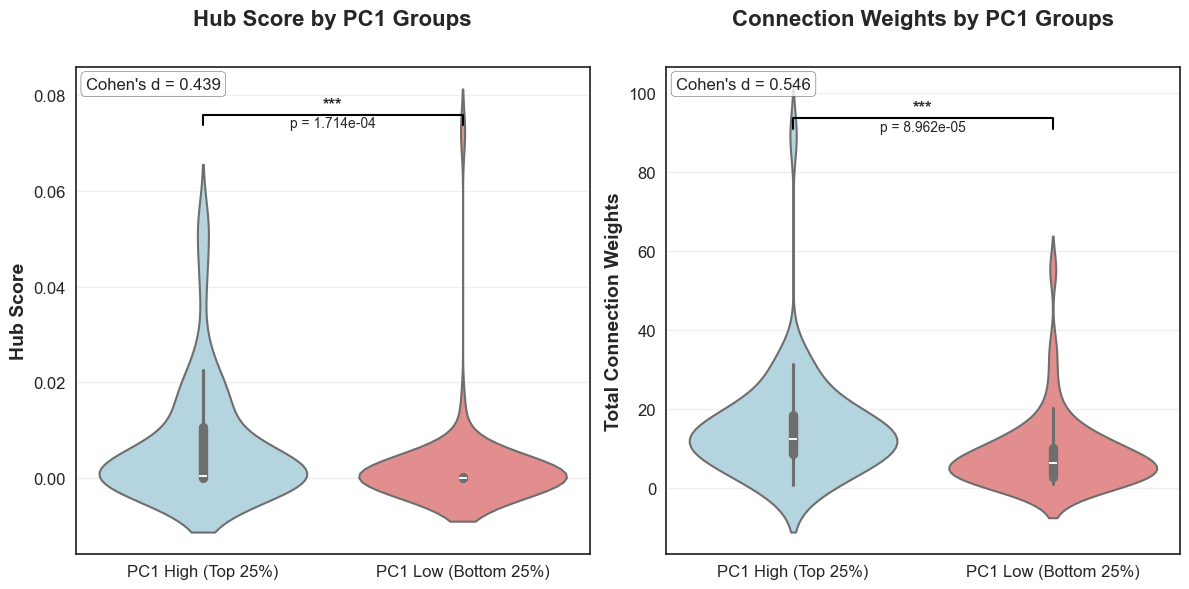

\nSummary Statistics:
                     Metric  PC1_High_Mean  PC1_Low_Mean   P_Value  \
0                 Hub Score       0.007003      0.002037  0.000171   
1  Total Connection Weights      14.829003      8.595903  0.000090   

   Effect_Size  Fold_Change  
0     0.439267     3.437263  
1     0.546448     1.725124  
\nSignificance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant
Effect size interpretation: small (0.2), medium (0.5), large (0.8)


In [ ]:
# Binarized analysis: PC1 High vs Low for Hub Score and Connection Weights
from scipy.stats import mannwhitneyu, ttest_ind
import seaborn as sns

# Define PC1 high and low groups (top and bottom 25%)
pc1_high_threshold = extended_df['PC1'].quantile(0.75)
pc1_low_threshold = extended_df['PC1'].quantile(0.25)

pc1_high_mask = extended_df['PC1'] >= pc1_high_threshold
pc1_low_mask = extended_df['PC1'] <= pc1_low_threshold

# Extract data for each group
pc1_high_hub = extended_df.loc[pc1_high_mask, 'hub_score']
pc1_low_hub = extended_df.loc[pc1_low_mask, 'hub_score']
pc1_high_weights = extended_df.loc[pc1_high_mask, 'total_all_weights']
pc1_low_weights = extended_df.loc[pc1_low_mask, 'total_all_weights']

# Statistical tests
hub_stat, hub_p = mannwhitneyu(pc1_high_hub, pc1_low_hub, alternative='two-sided')
weights_stat, weights_p = mannwhitneyu(pc1_high_weights, pc1_low_weights, alternative='two-sided')

# Calculate effect sizes (Cohen's d)
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(), group2.std()
    pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

hub_effect_size = cohens_d(pc1_high_hub, pc1_low_hub)
weights_effect_size = cohens_d(pc1_high_weights, pc1_low_weights)

print("PC1 High vs Low Group Comparisons:")
print("=" * 50)
print(f"Hub Score:")
print(f"  PC1 High (n={len(pc1_high_hub)}): median = {pc1_high_hub.median():.3f}, mean = {pc1_high_hub.mean():.3f}")
print(f"  PC1 Low (n={len(pc1_low_hub)}): median = {pc1_low_hub.median():.3f}, mean = {pc1_low_hub.mean():.3f}")
print(f"  Mann-Whitney U: p = {hub_p:.3e}, effect size (Cohen's d) = {hub_effect_size:.3f}")

print(f"\\nTotal Connection Weights:")
print(f"  PC1 High (n={len(pc1_high_weights)}): median = {pc1_high_weights.median():.3f}, mean = {pc1_high_weights.mean():.3f}")
print(f"  PC1 Low (n={len(pc1_low_weights)}): median = {pc1_low_weights.median():.3f}, mean = {pc1_low_weights.mean():.3f}")
print(f"  Mann-Whitney U: p = {weights_p:.3e}, effect size (Cohen's d) = {weights_effect_size:.3f}")

# Create publication-ready violin plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Customizable parameters
FONTSIZE_TITLE = 16
FONTSIZE_LABEL = 14
FONTSIZE_TICK = 12
FONTSIZE_STATS = 12
COLORS = ['lightblue', 'lightcoral']

def add_significance_annotation(ax, x1, x2, y, p_value, height_offset=0.05):
    """Add significance annotation between groups"""
    if p_value < 0.001:
        sig_text = '***'
    elif p_value < 0.01:
        sig_text = '**'
    elif p_value < 0.05:
        sig_text = '*'
    else:
        sig_text = 'ns'
    
    # Draw the bar
    bar_height = y + height_offset
    ax.plot([x1, x1, x2, x2], [y, bar_height, bar_height, y], 'k-', linewidth=1.5)
    
    # Add significance text
    ax.text((x1 + x2) / 2, bar_height + height_offset/3, sig_text, 
            ha='center', va='bottom', fontsize=FONTSIZE_STATS, fontweight='bold')
    
    # Add p-value
    ax.text((x1 + x2) / 2, bar_height + height_offset/3 - height_offset/2, 
            f'p = {p_value:.3e}', ha='center', va='top', fontsize=FONTSIZE_STATS-2)

# Prepare data for violin plots
hub_data = pd.DataFrame({
    'Group': ['PC1 High (Top 25%)'] * len(pc1_high_hub) + ['PC1 Low (Bottom 25%)'] * len(pc1_low_hub),
    'Hub Score': np.concatenate([pc1_high_hub, pc1_low_hub])
})

weights_data = pd.DataFrame({
    'Group': ['PC1 High (Top 25%)'] * len(pc1_high_weights) + ['PC1 Low (Bottom 25%)'] * len(pc1_low_weights),
    'Total Connection Weights': np.concatenate([pc1_high_weights, pc1_low_weights])
})

# Plot 1: Hub Score
ax1 = axes[0]
sns.violinplot(data=hub_data, x='Group', y='Hub Score', 
               palette=COLORS, ax=ax1, inner='box', linewidth=1.5)

ax1.set_ylabel('Hub Score', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax1.set_xlabel('')
ax1.set_title('Hub Score by PC1 Groups', fontsize=FONTSIZE_TITLE, fontweight='bold', pad=30)
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK)

# Add significance annotation
max_y1 = max(pc1_high_hub.max(), pc1_low_hub.max())
y_range1 = max_y1 - min(pc1_high_hub.min(), pc1_low_hub.min())
add_significance_annotation(ax1, 0, 1, max_y1 + 0.02 * y_range1, hub_p, 0.03 * y_range1)

# Add effect size annotation
ax1.text(0.02, 0.98, f"Cohen's d = {hub_effect_size:.3f}", 
         transform=ax1.transAxes, fontsize=FONTSIZE_STATS,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Total Connection Weights
ax2 = axes[1]
sns.violinplot(data=weights_data, x='Group', y='Total Connection Weights', 
               palette=COLORS, ax=ax2, inner='box', linewidth=1.5)

ax2.set_ylabel('Total Connection Weights', fontsize=FONTSIZE_LABEL, fontweight='bold')
ax2.set_xlabel('')
ax2.set_title('Connection Weights by PC1 Groups', fontsize=FONTSIZE_TITLE, fontweight='bold', pad=30)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='both', which='major', labelsize=FONTSIZE_TICK)

# Add significance annotation
max_y2 = max(pc1_high_weights.max(), pc1_low_weights.max())
y_range2 = max_y2 - min(pc1_high_weights.min(), pc1_low_weights.min())
add_significance_annotation(ax2, 0, 1, max_y2 + 0.02 * y_range2, weights_p, 0.03 * y_range2)

# Add effect size annotation
ax2.text(0.02, 0.98, f"Cohen's d = {weights_effect_size:.3f}", 
         transform=ax2.transAxes, fontsize=FONTSIZE_STATS,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Summary statistics table
print("\\nSummary Statistics:")
print("=" * 50)
summary_data = {
    'Metric': ['Hub Score', 'Total Connection Weights'],
    'PC1_High_Mean': [pc1_high_hub.mean(), pc1_high_weights.mean()],
    'PC1_Low_Mean': [pc1_low_hub.mean(), pc1_low_weights.mean()],
    'P_Value': [hub_p, weights_p],
    'Effect_Size': [hub_effect_size, weights_effect_size],
    'Fold_Change': [pc1_high_hub.mean()/pc1_low_hub.mean(), pc1_high_weights.mean()/pc1_low_weights.mean()]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)

print("\\nSignificance levels: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")
print("Effect size interpretation: small (0.2), medium (0.5), large (0.8)")

# Optional: Save the figure
# plt.savefig('PC1_binarized_comparison_violin.png', dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none')
# plt.savefig('PC1_binarized_comparison_violin.pdf', bbox_inches='tight', 
#             facecolor='white', edgecolor='none')

# Summary

This notebook analyzes the relationship between P-factor (PC scores) and brain connectivity patterns in mouse structures.

## Key Components:
1. **Data Loading**: Load bias matrices, PC scores, and connectivity data
2. **Connection Statistics**: Calculate incoming/outgoing connection counts and weights
3. **Correlation Analysis**: Compute Spearman correlations between PC scores and connectivity measures
4. **Visualization**: Generate scatter plots and regional boxplots

## Main Findings:
- Correlations between PC scores (especially PC1) and various connectivity measures
- Regional differences in PC1 scores across brain structures
- Both connection counts and weights show relationships with P-factor scores

The analysis provides insights into how P-factor relates to structural connectivity patterns in the mouse brain.